# Grid refactor

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
from collections import defaultdict
import csv
import pickle 

# 3rd party imports
import numpy as np
np.set_printoptions(linewidth=1000)
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.notebook import tqdm

# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian

## Functions

In [2]:
def create_correspondence(y: int, x: int, angle: int, magnitude: float, n: int = 7,
                          mpoint: np.ndarray = None) -> np.ndarray:
    """Create correspondences using given parameters.

    Args:
        y (int): Y-coordinate of the fixed point in grid space.
        x (int): X-coordinate of the fixed point in grid space.
        angle (int): Angle of the correspondence (degrees).
        magnitude (float): Magnitude of the correspondence.
        n (int, optional): Size of the grid. Defaults to 7.
        mpoint (np.ndarray, optional): Corresponding points in the frame image. Defaults to None. Used if provided.

    Returns:
        np.ndarray: Computed fixed point from the parameters
    """
    angle_rad = np.radians(angle)
    
    # If a moving point is provided, use it as the reference point
    if mpoint is not None:
        mpoint = np.array(mpoint)
        if mpoint.shape != (3,):
            raise ValueError("Matched points must be a 3x1 vector.")
        fpoint = mpoint + np.array([0, magnitude * np.sin(angle_rad), magnitude * np.cos(angle_rad)])
    # Otherwise, use the provided coordinates
    else:
        # Convert to original [0, n) coordinate space.
        ny = y + n // 2
        nx = x + n // 2
        mpoint = np.array([0, ny, nx])
        fpoint = mpoint + np.array([0, magnitude * np.sin(angle_rad), magnitude * np.cos(angle_rad)])
    
    fpoint = np.rint(fpoint).astype(int)
    
    # Check bounds
    if np.min(mpoint) < 0 or np.max(mpoint) >= n or np.min(fpoint) < 0 or np.max(fpoint) >= n:
        print("Warning: Correspondence out of bounds.")
    return mpoint, fpoint


def create_base_correspondence(magnitude: float = 1, n: int = 7) -> np.ndarray:
    """Create the base correspondence for the grid at the center.

    Args:
        magnitude (float, optional): Magnitude of the correspondence. Defaults to 1.
        n (int, optional): Number of angles to consider. Defaults to 7.

    Returns:
        np.ndarray: Base correspondence (moving point and fixed point)
    """
    return np.array([0, n // 2, n // 2]), np.array([[0, n // 2, n // 2 + magnitude]])
    
print(create_correspondence(y=1, x=2, angle=0, magnitude=1.0, n=7))
bmp, bfp = create_base_correspondence(magnitude=1, n=7)
print(bmp, bfp)

(array([0, 4, 5]), array([0, 4, 6]))
[0 3 3] [[0 3 4]]


In [3]:
class Grid:
    def __init__(self, mpoints: np.ndarray, fpoints: np.ndarray, n: int = 7):
        self.mpoints = mpoints
        self.fpoints = fpoints
        self.n = n
        
        self._create_grid()

        
    def _create_grid(self):
        """Create a grid of correspondences between matched points.

        Args:
            mpoints (np.ndarray): Matched points in the model image.
            fpoints (np.ndarray): Corresponding points in the frame image.
        """
        # Run Laplacian and Jacobian determinant calculations and save the Jacobian determinant field
        grid_resolution = np.zeros((1, self.n, self.n))
        self.deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(grid_resolution, self.mpoints, self.fpoints)
        self.jdet_field = jacobian.sitk_jacobian_determinant(self.deformation)[0]
        
        
    def min(self):
        """Get the minimum Jacobian determinant value.
        
        Returns:
            float: Minimum Jacobian determinant value in the field.
        """
        return self.jdet_field.min()
        
        
    def upsample(self, scale: int):
        """Resample the deformation field and the Jacobian determinant field using a scaling factor.
        
        Args:
            scale (int): Upsampling factor.
            
        Returns:
            Grid: Upsampled grid.
        """
        if scale <= 1:
            raise ValueError("Upsampling factor must be greater than 1.")
        scaled_n = self.n * scale
        mpoints = self.mpoints.copy()
        fpoints = self.fpoints.copy()
        # Scale only y and x of mpoints and fpoints
        mpoints[:, 1:] -= self.n // 2
        fpoints[:, 1:] -= self.n // 2
        mpoints[:, 1:] *= scale
        fpoints[:, 1:] *= scale
        mpoints[:, 1:] += scaled_n // 2
        fpoints[:, 1:] += scaled_n // 2
        return Grid(mpoints, fpoints, scaled_n)
    
    
    def downsample(self, n: int):
        """Downsample the deformation field to a new grid size n and recompute the Jacobian determinant field.
        
        Args:
            n (int): New grid size.
            
        Returns:
            Grid: Downsampled grid.
        """
        downsampled_displacement_field = np.zeros((3, 1, n, n))
        scale = self.n // n
        mpoints = []
        fpoints = []
        
        # Convert current mpoints and fpoints to downsampled locations
        for i in range(len(self.mpoints)):
            mpt = self.mpoints[i].copy()
            fpt = self.fpoints[i].copy()
            # Compute new locations
            mpt[1:] -= self.n // 2
            mpt[1:] //= scale
            mpt[1:] += n // 2
            fpt[1:] -= self.n // 2
            fpt[1:] //= scale
            fpt[1:] += n // 2
            # Save to array
            mpoints.append(mpt)
            fpoints.append(fpt)
        mpoints = np.array(mpoints)
        fpoints = np.array(fpoints)
        
        # Fill out the new downsampled displacement field
        for y in range(n):
            for x in range(n):
                # Get the current y and x coordinates in the larger (current) grid
                curr_y = y - (n // 2)
                curr_y *= scale
                curr_y += self.n // 2
                curr_x = x - (n // 2)
                curr_x *= scale
                curr_x += self.n // 2
                # Set the new displacement field
                curr_displacement = self.deformation[:, 0, curr_y, curr_x]
                displacement_y = curr_displacement[1] / scale
                displacement_x = curr_displacement[2] / scale
                downsampled_displacement_field[0, 0, y, x] = 0
                downsampled_displacement_field[1, 0, y, x] = displacement_y
                downsampled_displacement_field[2, 0, y, x] = displacement_x
                
        # Generate the new grid
        g = Grid(mpoints, fpoints, n)
        g.deformation = downsampled_displacement_field
        g.jdet_field = jacobian.sitk_jacobian_determinant(downsampled_displacement_field)[0]
        return g
    
    
    def _compute_derivatives(self, x, y):
        deform = self.deformation[1:, 0, :, :]
        displacement_y = deform[0]
        displacement_x = deform[1]
    
        curr = (displacement_y[y, x], displacement_x[y, x])
        if x == 0 and y == 0:  # Top-left corner
            right = (displacement_y[y, x+1], displacement_x[y, x+1])
            down = (displacement_y[y+1, x], displacement_x[y+1, x])
            dxdx = (right[1] - curr[1]) / 2
            dydx = (right[0] - curr[0]) / 2
            dydy = (down[0] - curr[0]) / 2
            dxdy = (down[1] - curr[1]) / 2
        elif x == self.n - 1 and y == 0:  # Top-right corner
            left = (displacement_y[y, x-1], displacement_x[y, x-1])
            down = (displacement_y[y+1, x], displacement_x[y+1, x])
            dxdx = (curr[1] - left[1]) / 2
            dydx = (curr[0] - left[0]) / 2
            dydy = (down[0] - curr[0]) / 2
            dxdy = (down[1] - curr[1]) / 2
        elif x == 0 and y == self.n - 1:  # Bottom-left corner
            right = (displacement_y[y, x+1], displacement_x[y, x+1])
            up = (displacement_y[y-1, x], displacement_x[y-1, x])
            dxdx = (right[1] - curr[1]) / 2
            dydx = (right[0] - curr[0]) / 2
            dydy = (curr[0] - up[0]) / 2
            dxdy = (curr[1] - up[1]) / 2
        elif x == self.n - 1 and y == self.n - 1:  # Bottom-right corner
            left = (displacement_y[y, x-1], displacement_x[y, x-1])
            up = (displacement_y[y-1, x], displacement_x[y-1, x])
            dxdx = (curr[1] - left[1]) / 2
            dydx = (curr[0] - left[0]) / 2
            dydy = (curr[0] - up[0]) / 2
            dxdy = (curr[1] - up[1]) / 2
        elif x == 0:  # Left edge
            right = (displacement_y[y, x+1], displacement_x[y, x+1])
            up = (displacement_y[y-1, x], displacement_x[y-1, x])
            down = (displacement_y[y+1, x], displacement_x[y+1, x])
            dxdx = (right[1] - curr[1]) / 2
            dydx = (right[0] - curr[0]) / 2
            dydy = (down[0] - up[0]) / 2
            dxdy = (down[1] - up[1]) / 2
        elif y == 0:  # Top edge
            down = (displacement_y[y+1, x], displacement_x[y+1, x])
            right = (displacement_y[y, x+1], displacement_x[y, x+1])
            left = (displacement_y[y, x-1], displacement_x[y, x-1])
            dxdx = (right[1] - left[1]) / 2
            dydx = (right[0] - left[0]) / 2
            dydy = (down[0] - curr[0]) / 2
            dxdy = (down[1] - curr[1]) / 2
        elif x == self.n - 1:  # Right edge
            left = (displacement_y[y, x-1], displacement_x[y, x-1])
            up = (displacement_y[y-1, x], displacement_x[y-1, x])
            down = (displacement_y[y+1, x], displacement_x[y+1, x])
            dxdx = (curr[1] - left[1]) / 2
            dydx = (curr[0] - left[0]) / 2
            dydy = (down[0] - up[0]) / 2
            dxdy = (down[1] - up[1]) / 2
        elif y == self.n - 1:  # Bottom edge
            up = (displacement_y[y-1, x], displacement_x[y-1, x])
            right = (displacement_y[y, x+1], displacement_x[y, x+1])
            left = (displacement_y[y, x-1], displacement_x[y, x-1])
            dxdx = (right[1] - left[1]) / 2
            dydx = (right[0] - left[0]) / 2
            dydy = (curr[0] - up[0]) / 2
            dxdy = (curr[1] - up[1]) / 2
        else:  # Interior points
            right = (displacement_y[y, x+1], displacement_x[y, x+1])
            left = (displacement_y[y, x-1], displacement_x[y, x-1])
            up = (displacement_y[y-1, x], displacement_x[y-1, x])
            down = (displacement_y[y+1, x], displacement_x[y+1, x])
            dxdx = (right[1] - left[1]) / 2
            dydy = (down[0] - up[0]) / 2
            dxdy = (down[1] - up[1]) / 2
            dydx = (right[0] - left[0]) / 2
        return dxdx, dydy, dxdy, dydx
    
    
    def derivative(self):
        """Compute the derivative of the Jacobian determinant field.
        """
        derivative_field = np.zeros((self.n, self.n))
        for y in range(self.n):
            for x in range(self.n):
                dxdx, dydy, dxdy, dydx = self._compute_derivatives(x, y)
                derived_coefficients = 2 * dxdx * dydy
                linear_term = dxdx + dydy
                deriv_func = derived_coefficients + linear_term
                derivative_field[y, x] = deriv_func
        return derivative_field
        
    
    def show_derivative(self, figsize: tuple = (10, 5), fontsize: float = 12, title: str = f"Derivative of Jacobian determinant"):
        """Show the derivative of the Jacobian determinant field.
        
        Args:
            figsize (tuple, optional): Size of the plot. Defaults to (10, 5).
        """
        norm = mcolors.TwoSlopeNorm(vmin=min(self.jdet_field.min(), -1), vcenter=0, vmax=self.jdet_field.max())
        derivative_field = self.derivative()
        
        f = plt.figure(figsize=figsize)
        plt.imshow(self.jdet_field, cmap='seismic', norm=norm)
        plt.colorbar()
        plt.title(title)
        
        # Draw correspondence arrows
        for i in range(self.mpoints.shape[0]):
            plt.arrow(self.mpoints[i, 2], self.mpoints[i, 1], self.fpoints[i, 2] - self.mpoints[i, 2], self.fpoints[i, 1] - self.mpoints[i, 1],
                      head_width=0.15, head_length=0.15, fc='black', ec='black')
        
        # Draw the derivative values
        for y in range(self.n):
            for x in range(self.n):
                curr_derivative = derivative_field[y, x]
                text_color = 'black'
                derivative_str = "\n"
                if curr_derivative < 0:
                    derivative_str = "-\n"
                    text_color = 'blue'
                elif curr_derivative > 0:
                    derivative_str = "+\n"
                    text_color = 'green'
                derivative_str += f"{curr_derivative:.2f}"
                plt.text(x, y, derivative_str, color=text_color, ha='center', va='center', fontsize=fontsize, weight='bold')
        plt.show()
        f.clear()
        plt.close(f)
    
    
    def show(self, title: str = None, figsize: tuple = (10, 5), fontsize: int = 6):
        """Show the deformation field and the Jacobian determinant field.
        
        Args:
            title (str, optional): Title of the plot. Defaults to None.
            figsize (tuple, optional): Size of the plot. Defaults to (10, 5).
            fontsize (int, optional): Font size of the text. Defaults to 6.
        """
        norm = mcolors.TwoSlopeNorm(vmin=min(self.jdet_field.min(), -1), vcenter=0, vmax=self.jdet_field.max())

        f = plt.figure(figsize=figsize)
        plt.imshow(self.jdet_field, cmap="seismic", norm=norm)
        plt.colorbar()
        
        # Draw correspondence arrows
        for i in range(self.mpoints.shape[0]):
            plt.arrow(self.mpoints[i, 2], self.mpoints[i, 1], self.fpoints[i, 2] - self.mpoints[i, 2], self.fpoints[i, 1] - self.mpoints[i, 1],
                      head_width=0.15, head_length=0.15, fc='g', ec='g')
            
        # Plot the coordinate text
        for y in range(self.jdet_field.shape[0]):
            for x in range(self.jdet_field.shape[1]):
                # Get the pixel information                
                curr_displacement = self.deformation[:, 0, y, x]  # Get first slice (only slice)
                displacement_y = curr_displacement[1]
                displacement_x = curr_displacement[2]

                # Get the angle information
                curr_theta_rad = np.arctan2(displacement_y, displacement_x)
                if curr_theta_rad < 0:  # Ensure the angle is in the range [0, 2pi)
                    curr_theta_rad += 2 * np.pi
                curr_theta = np.abs(np.degrees(curr_theta_rad))
                
                # Get the magnitude information
                curr_magnitude = np.linalg.norm(curr_displacement)
                jdet = self.jdet_field[y, x]
                
                # Setup text to display
                coord_text = f"({displacement_y:.2f}, {displacement_x:.2f})\n"
                jdet_text = f"{jdet:.2f} J"
                vector_text = f"\n{curr_theta:.2f}°\n" + f"∥{curr_magnitude:.2f}∥"
                #pixel_text = coord_text + jdet_text + vector_text
                pixel_text = coord_text + jdet_text
                plt.text(x, y, pixel_text, color='black', ha='center', va='center', fontsize=fontsize, weight='normal')
                                
                # Draw the vector direction
                magnitude_scale = 0.33  # To scale the vector magnitude for visualization purposes
                #plt.arrow(x, y, np.cos(curr_theta_rad) * magnitude_scale, np.sin(curr_theta_rad) * magnitude_scale, head_width=0.15, head_length=0.15, fc='black', ec='black')            

        if title is None:
            title = f"{self.n}x{self.n} Jacobian determinants"
        plt.title(title)
        plt.xticks(np.arange(self.jdet_field.shape[0]), labels=np.arange(-(self.jdet_field.shape[1] // 2) - 1, self.jdet_field.shape[1] // 2) + 1)
        plt.yticks(np.arange(self.jdet_field.shape[0]), labels=np.arange(-(self.jdet_field.shape[0] // 2) - 1, self.jdet_field.shape[0] // 2) + 1)
        plt.show()
        f.clear()
        plt.close(f)

## Tests

In [4]:
def create_case(y: int, x: int, theta: int, magnitude: float, base_magnitude: float = 1, n: int = 7,
                title: str = None, figsize: tuple = (10, 5), fontsize: int = 6,
                mpoint: np.ndarray = None, fpoint: np.ndarray = None, show=True) -> Grid:
    """Create a case for a single correspondence.

    Args:
        y (int): Y coordinate of the correspondence.
        x (int): X coordinate of the correspondence.
        theta (int): Angle of the correspondence (degrees).
        magnitude (float): Magnitude of the correspondence.
        n (int, optional): Size of grid to consider. Defaults to 7.

    Returns:
        np.ndarray: Grid of correspondences.
    """
    # If mpoint and fpoint are provided, use that. 
    if mpoint is not None and fpoint is not None:
        mpoint = np.array([mpoint])
        fpoint = np.array([fpoint])
    # Otherwise, create the correspondence using the parameters
    else:
        # Convert to original [0, n) coordinate space.
        mpoint, fpoint = create_correspondence(y=y, x=x, angle=theta, magnitude=magnitude, n=n)
    
    # Create the base correspondence
    base_mpoint, base_fpoint = create_base_correspondence(base_magnitude, n)
    
    # Merge the correspondences
    mpoints = np.vstack((base_mpoint, mpoint))
    fpoints = np.vstack((base_fpoint, fpoint))
        
    # Create the grid of correspondences
    g = Grid(mpoints, fpoints, n)
    if show:
        if title is None:
            title = f"Correspondence at ({y}, {x})\ntheta={theta}°, mag={magnitude}"
        g.show(title=title, figsize=figsize, fontsize=fontsize)
    return g

### Positional symmetry

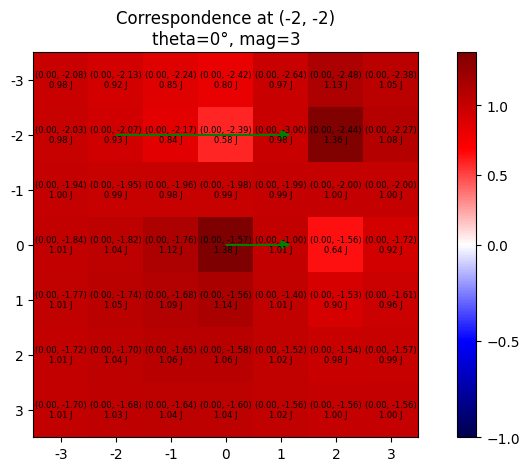

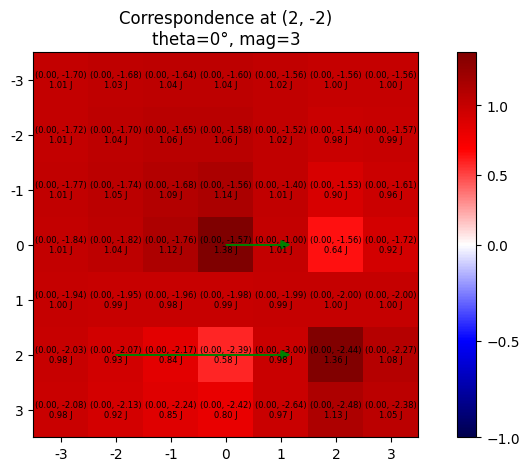

In [22]:
# Case 1
y, x = (-2, -2)
theta = 0
magnitude = 3
n = 7
g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)

y, x = (2, -2)
theta = 0
magnitude = 3
n = 7
g2 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)

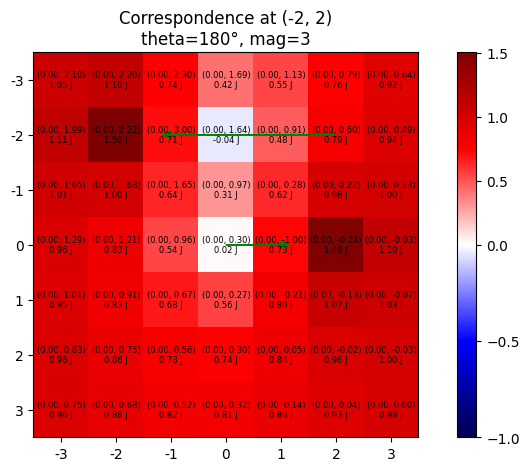

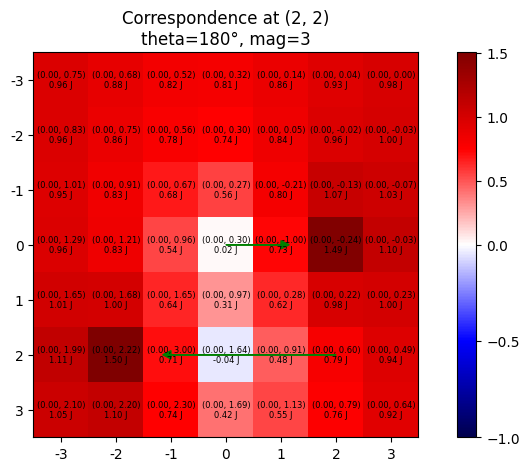

In [23]:
# Case 2
y, x = (-2, 2)
theta = 180
magnitude = 3
n = 7
g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)

y, x = (2, 2)
theta = 180
magnitude = 3
n = 7
g2 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)

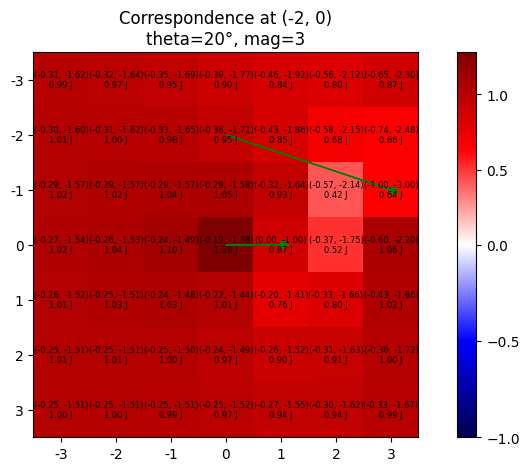

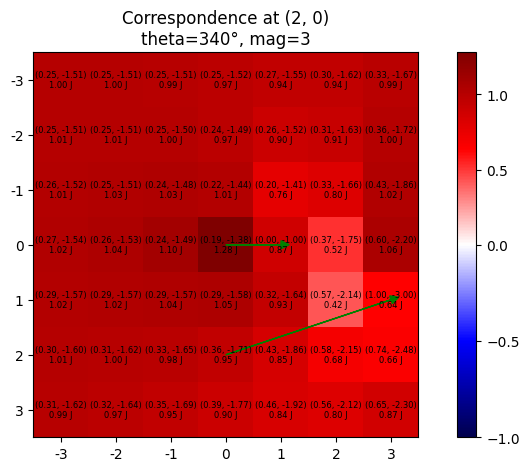

In [24]:
# Case 3
y, x = (-2, 0)
theta = 20
magnitude = 3
n = 7
g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)

y, x = (2, 0)
theta = 340
magnitude = 3
n = 7
g2 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)

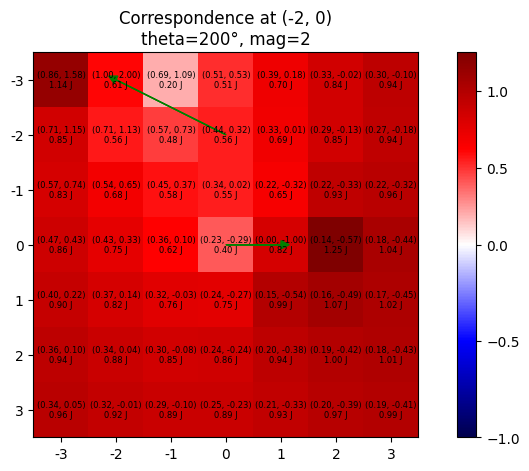

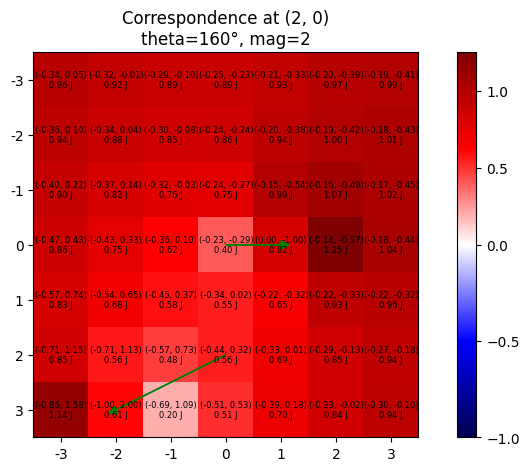

In [25]:
# Case 4
y, x = (-2, 0)
theta = 200
magnitude = 2
n = 7
g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)

y, x = (2, 0)
theta = 160
magnitude = 2
n = 7
g2 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)

### 21x21 magnitude test

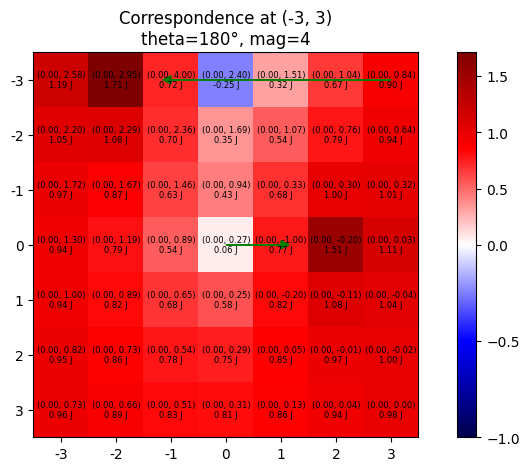

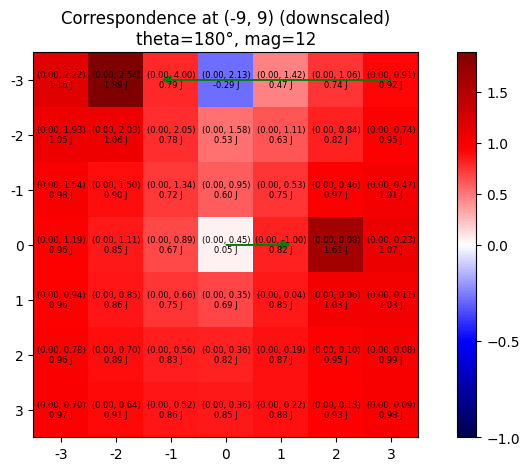

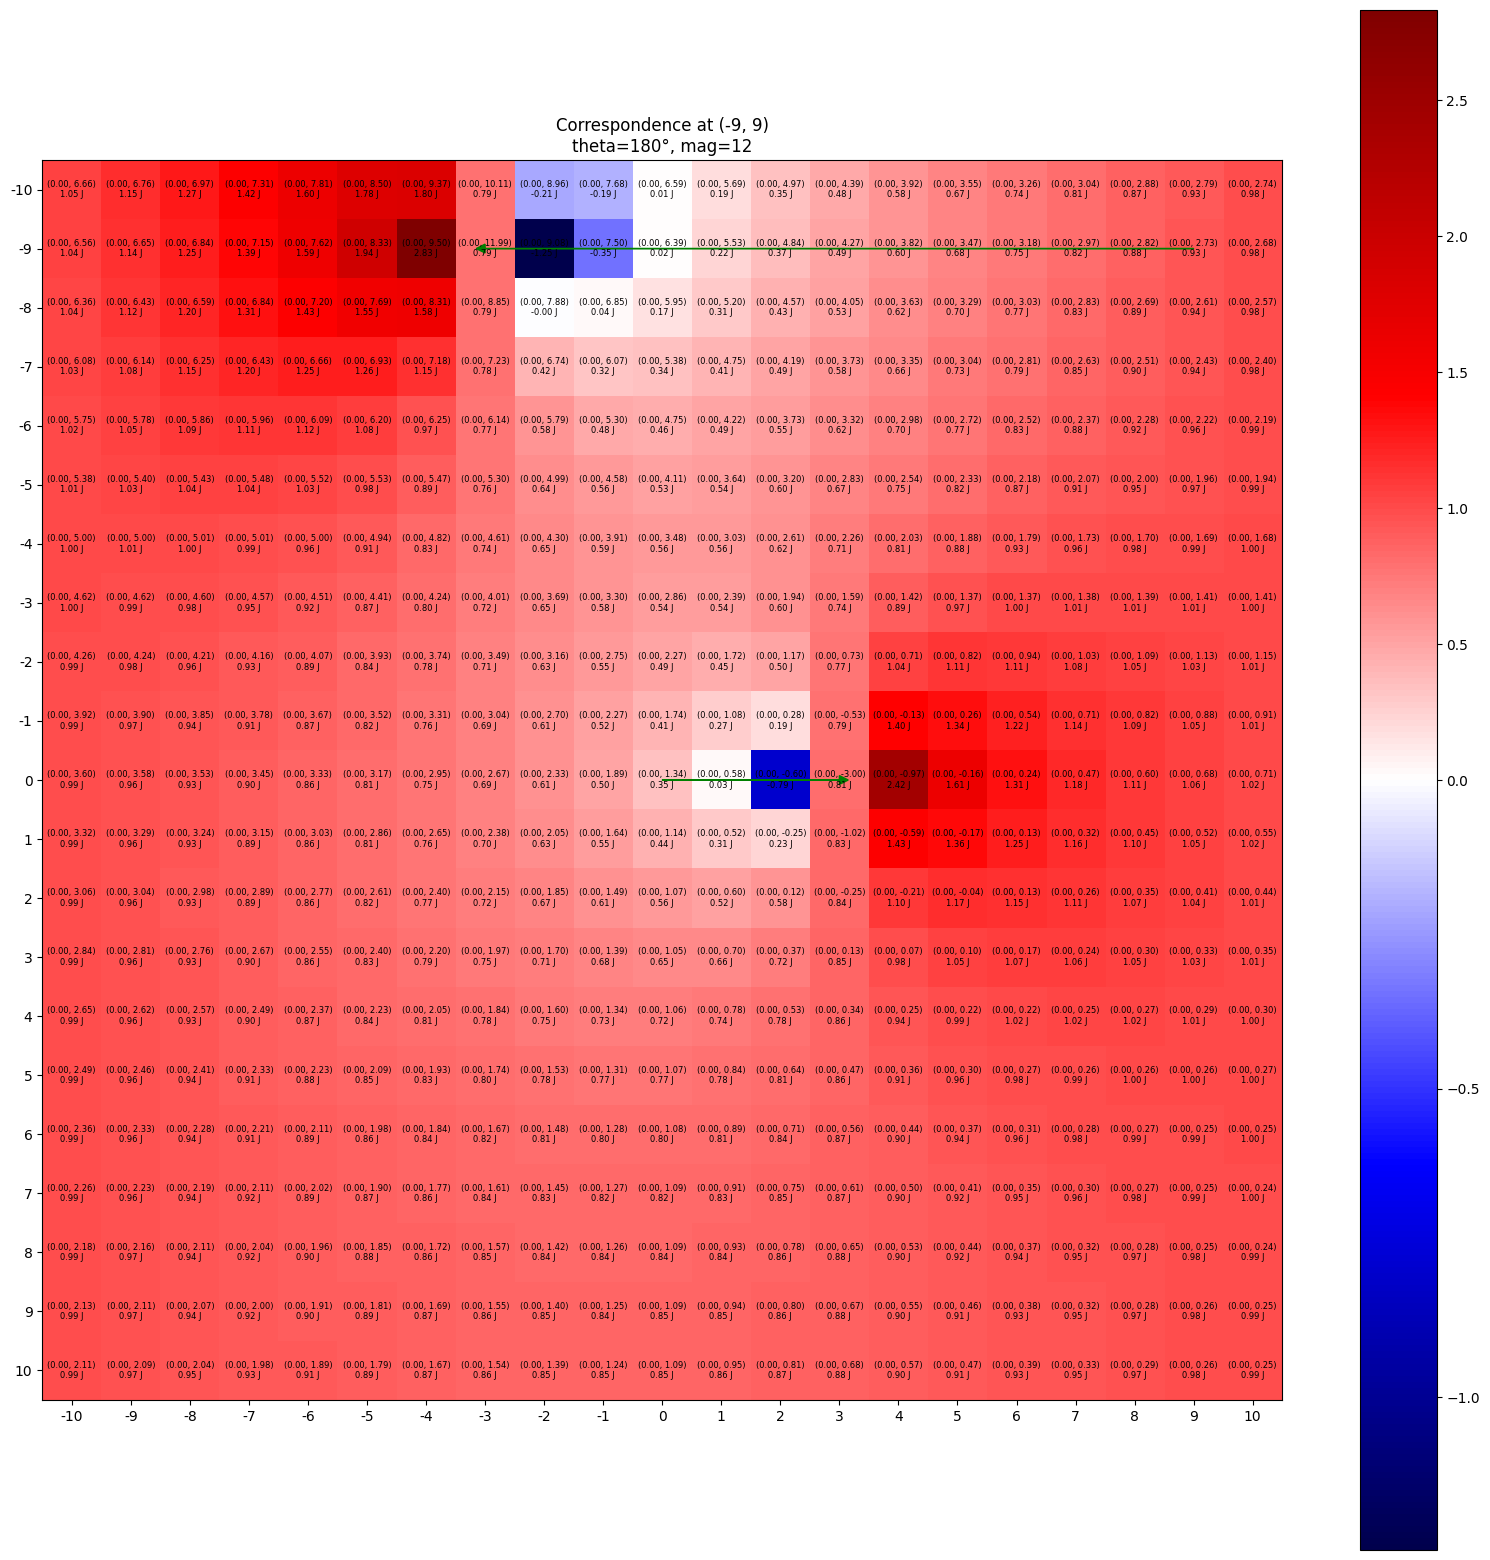

In [37]:
# Case 1
y, x = (-3, 3)
theta = 180
magnitude = 4
n = 7
scale = 3

g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)
g2 = g1.upsample(scale)
g2.downsample(n).show(title=f"Correspondence at ({y * scale}, {x * scale}) (downscaled)\ntheta={theta}°, mag={magnitude * scale}")
g2.show(title=f"Correspondence at ({y * scale}, {x * scale})\ntheta={theta}°, mag={magnitude * scale}", figsize=(20, 20), fontsize=6)

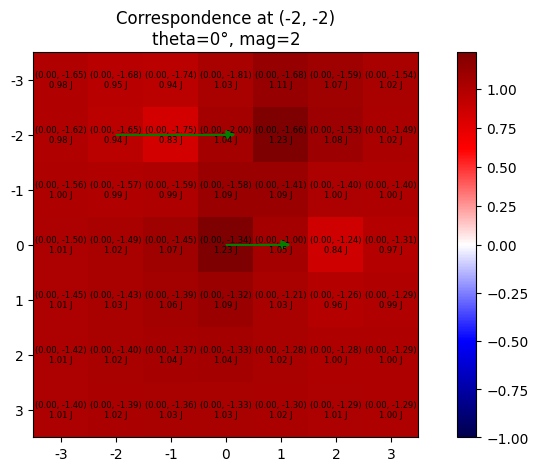

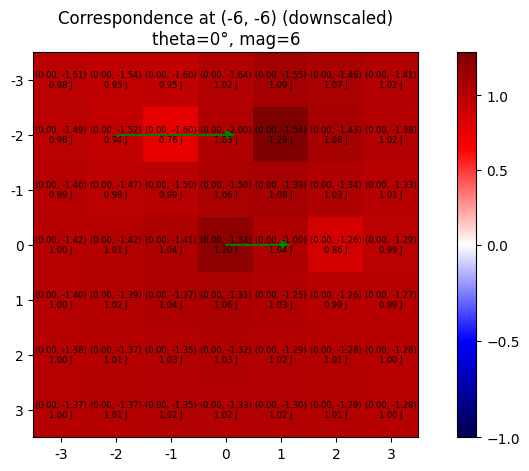

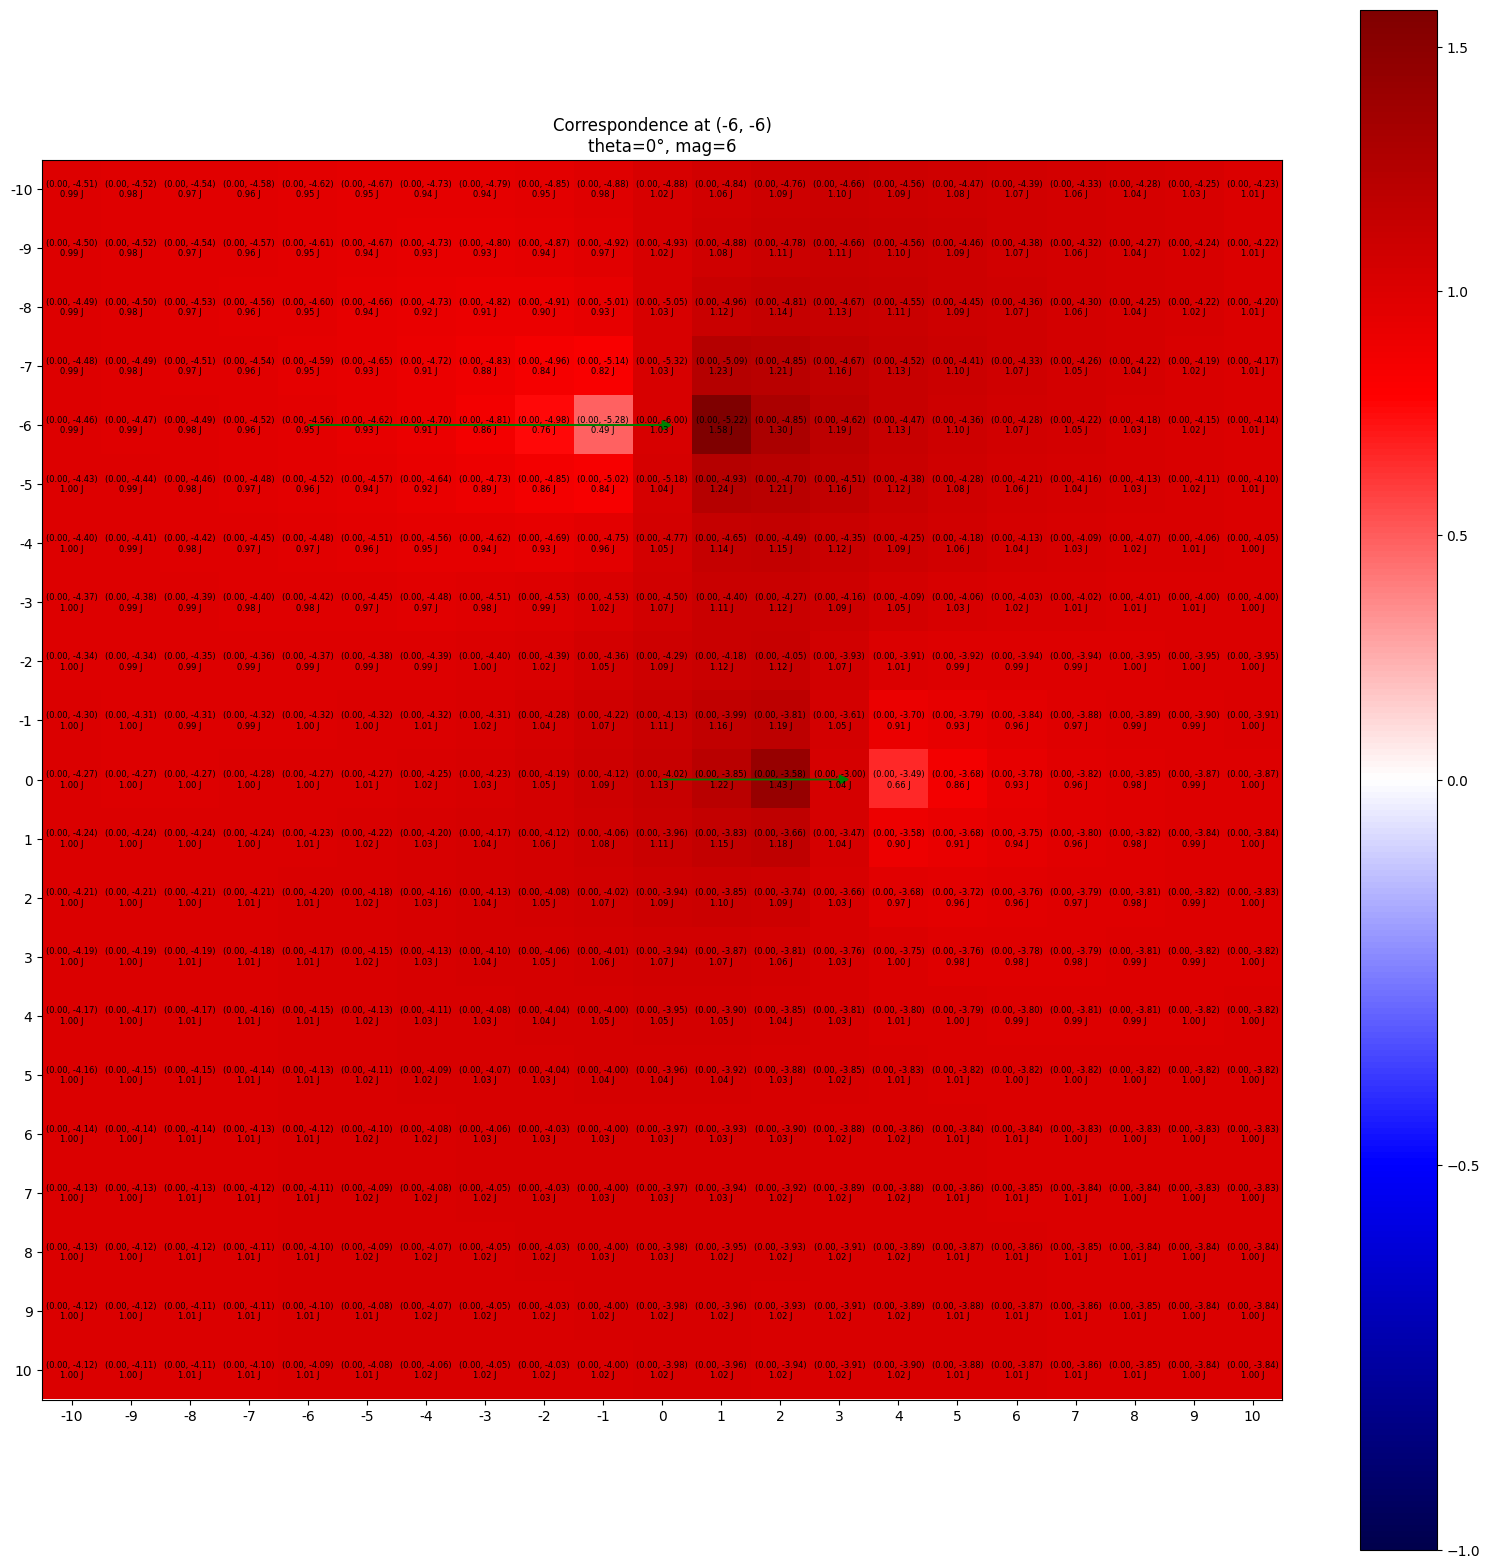

In [39]:
# Case 2
y, x = (-2, -2)
theta = 0
magnitude = 2
n = 7
scale = 3

g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)
g2 = g1.upsample(scale)
g2.downsample(n).show(title=f"Correspondence at ({y * scale}, {x * scale}) (downscaled)\ntheta={theta}°, mag={magnitude * scale}")
g2.show(title=f"Correspondence at ({y * scale}, {x * scale})\ntheta={theta}°, mag={magnitude * scale}", figsize=(20, 20), fontsize=6)

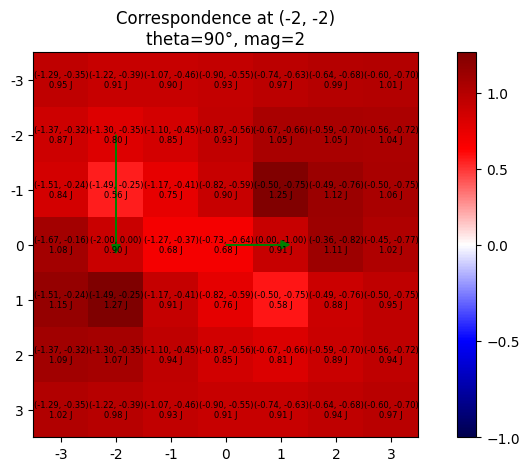

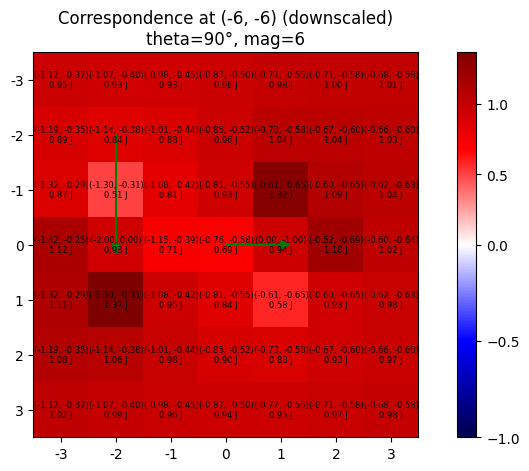

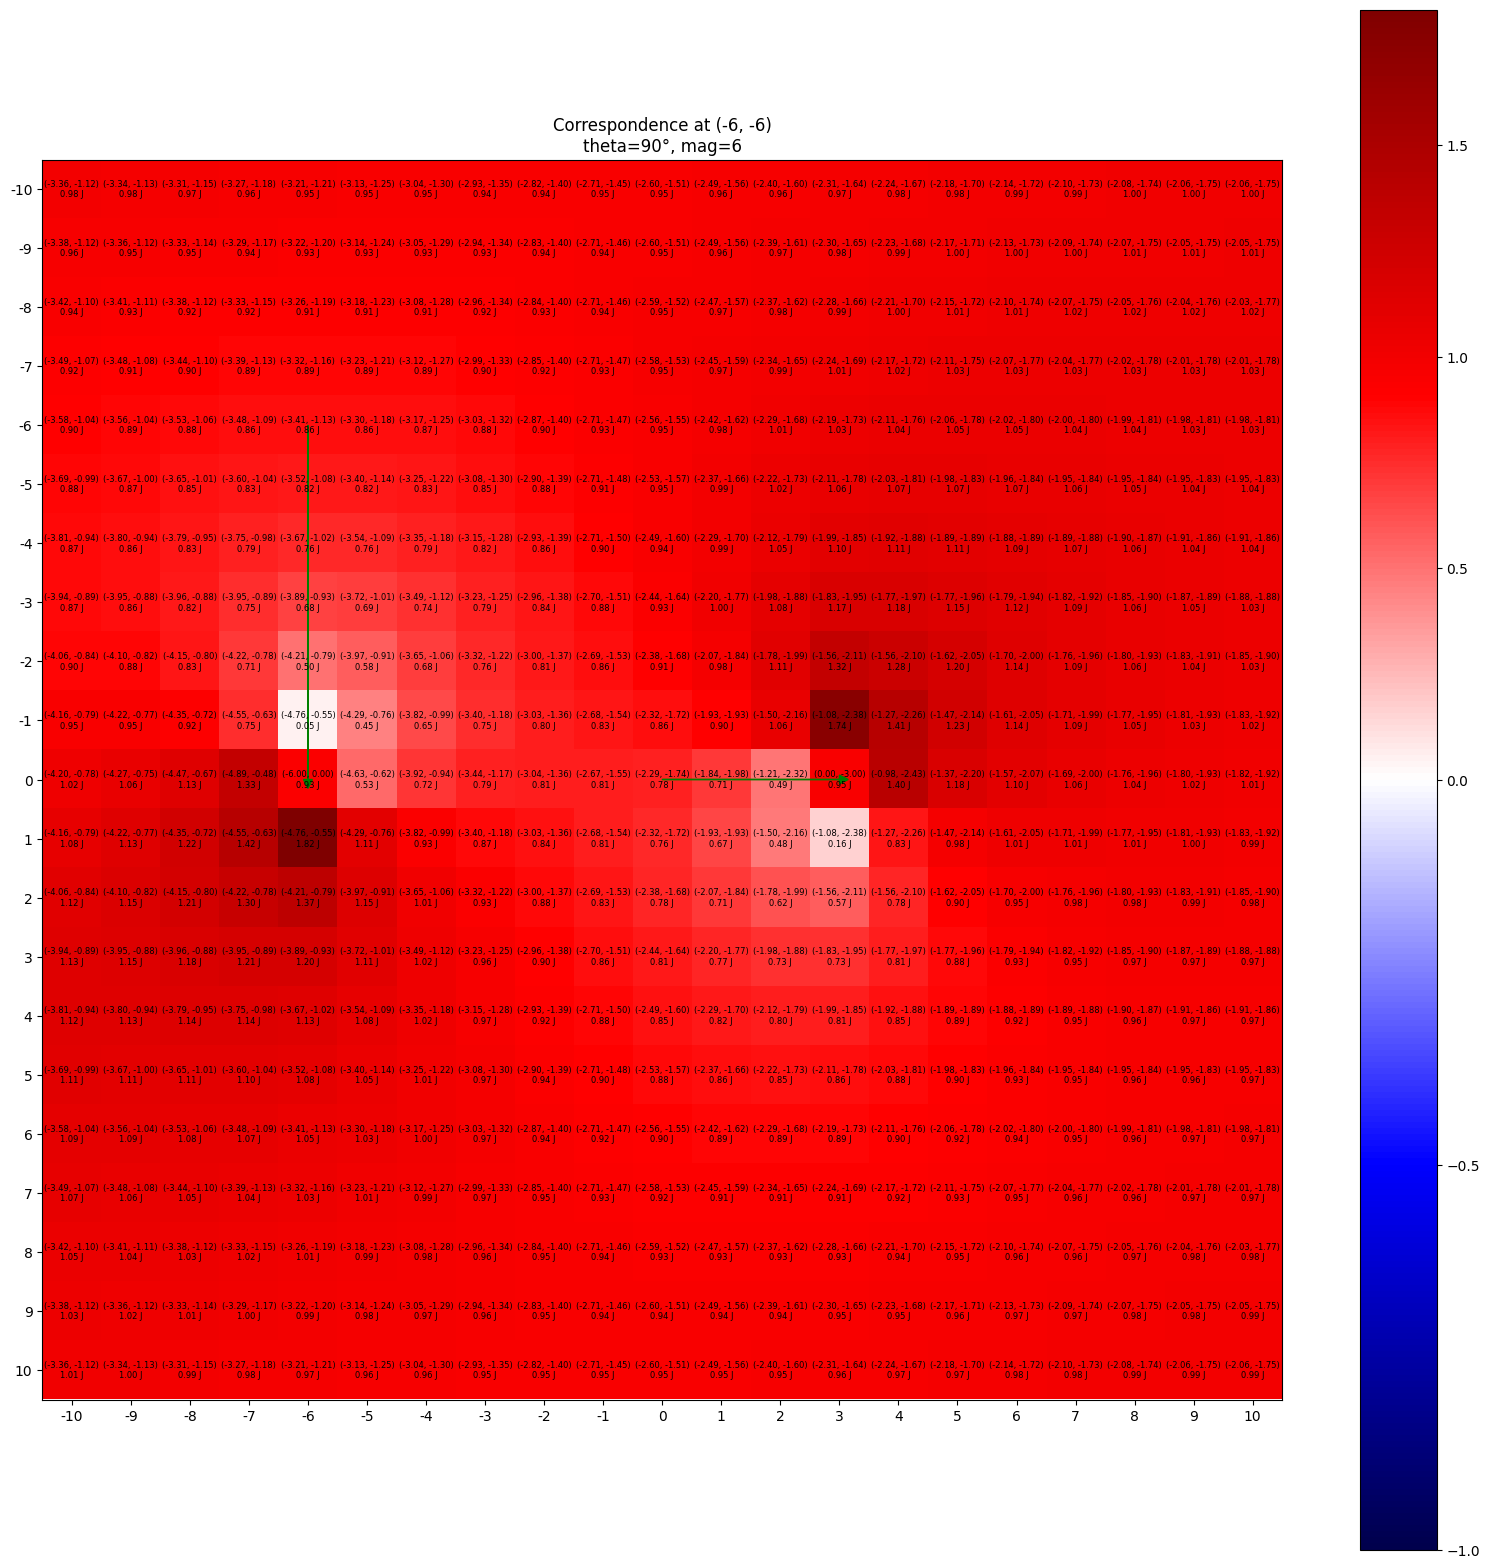

In [40]:
# Case 3
y, x = (-2, -2)
theta = 90
magnitude = 2
n = 7
scale = 3

g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)
g2 = g1.upsample(scale)
g2.downsample(n).show(title=f"Correspondence at ({y * scale}, {x * scale}) (downscaled)\ntheta={theta}°, mag={magnitude * scale}")
g2.show(title=f"Correspondence at ({y * scale}, {x * scale})\ntheta={theta}°, mag={magnitude * scale}", figsize=(20, 20), fontsize=6)

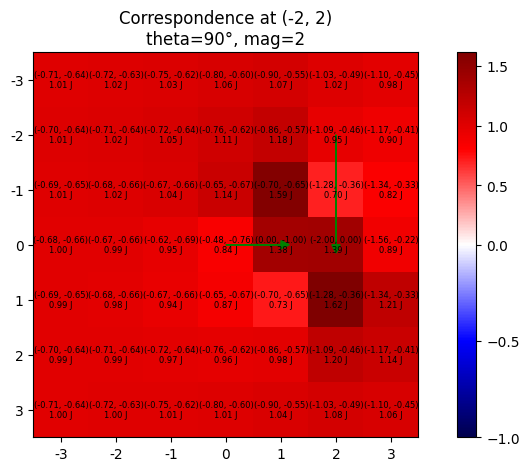

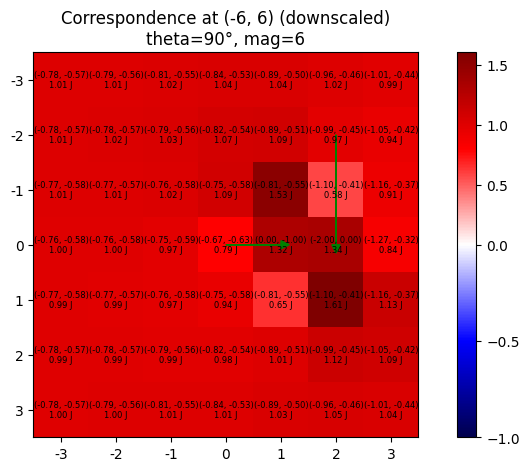

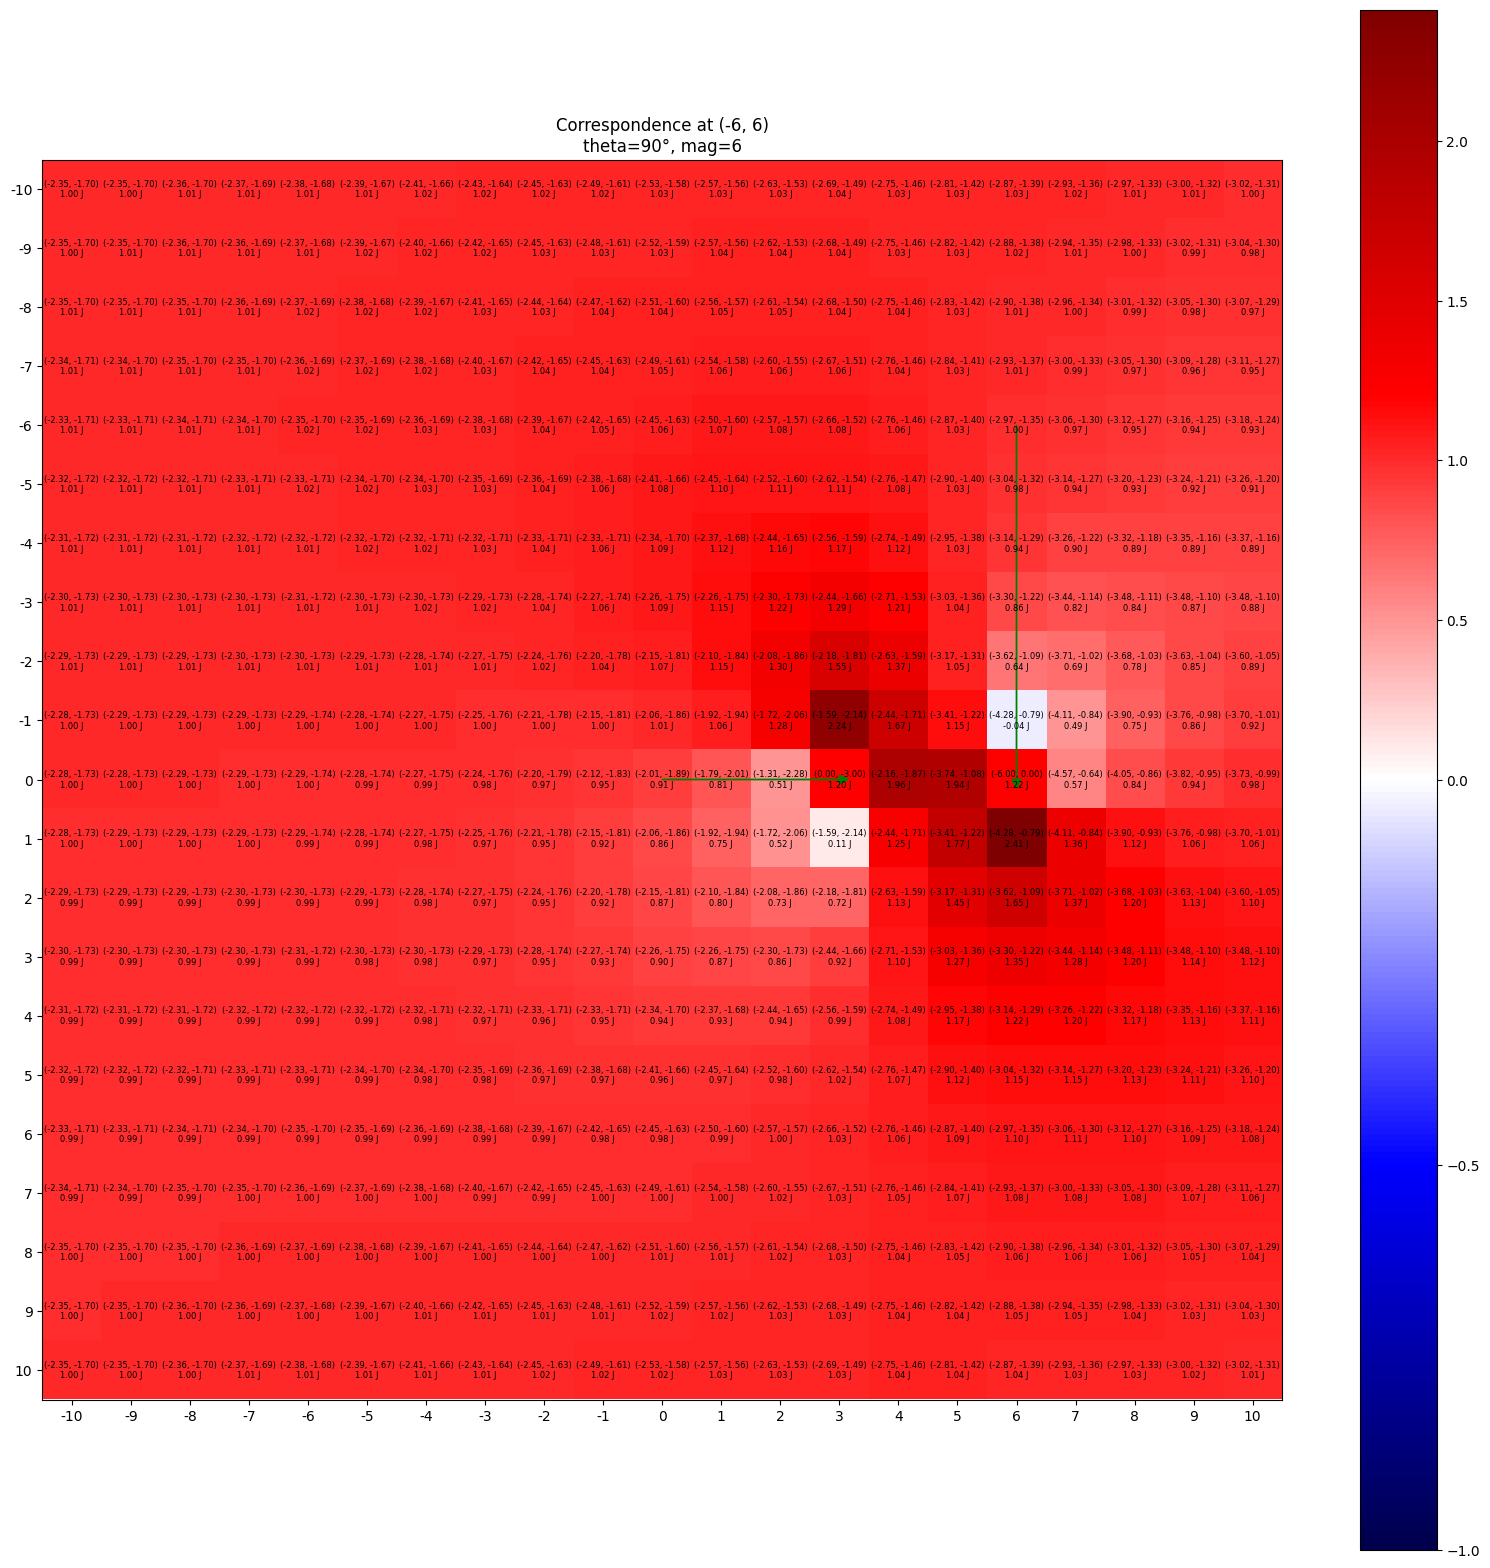

In [41]:
# Case 4
y, x = (-2, 2)
theta = 90
magnitude = 2
n = 7
scale = 3

g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)
g2 = g1.upsample(scale)
g2.downsample(n).show(title=f"Correspondence at ({y * scale}, {x * scale}) (downscaled)\ntheta={theta}°, mag={magnitude * scale}")
g2.show(title=f"Correspondence at ({y * scale}, {x * scale})\ntheta={theta}°, mag={magnitude * scale}", figsize=(20, 20), fontsize=6)

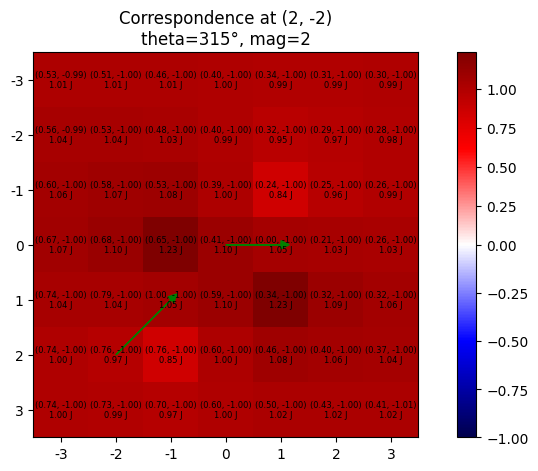

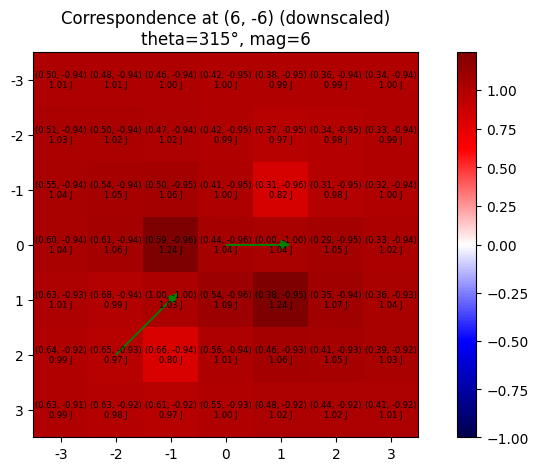

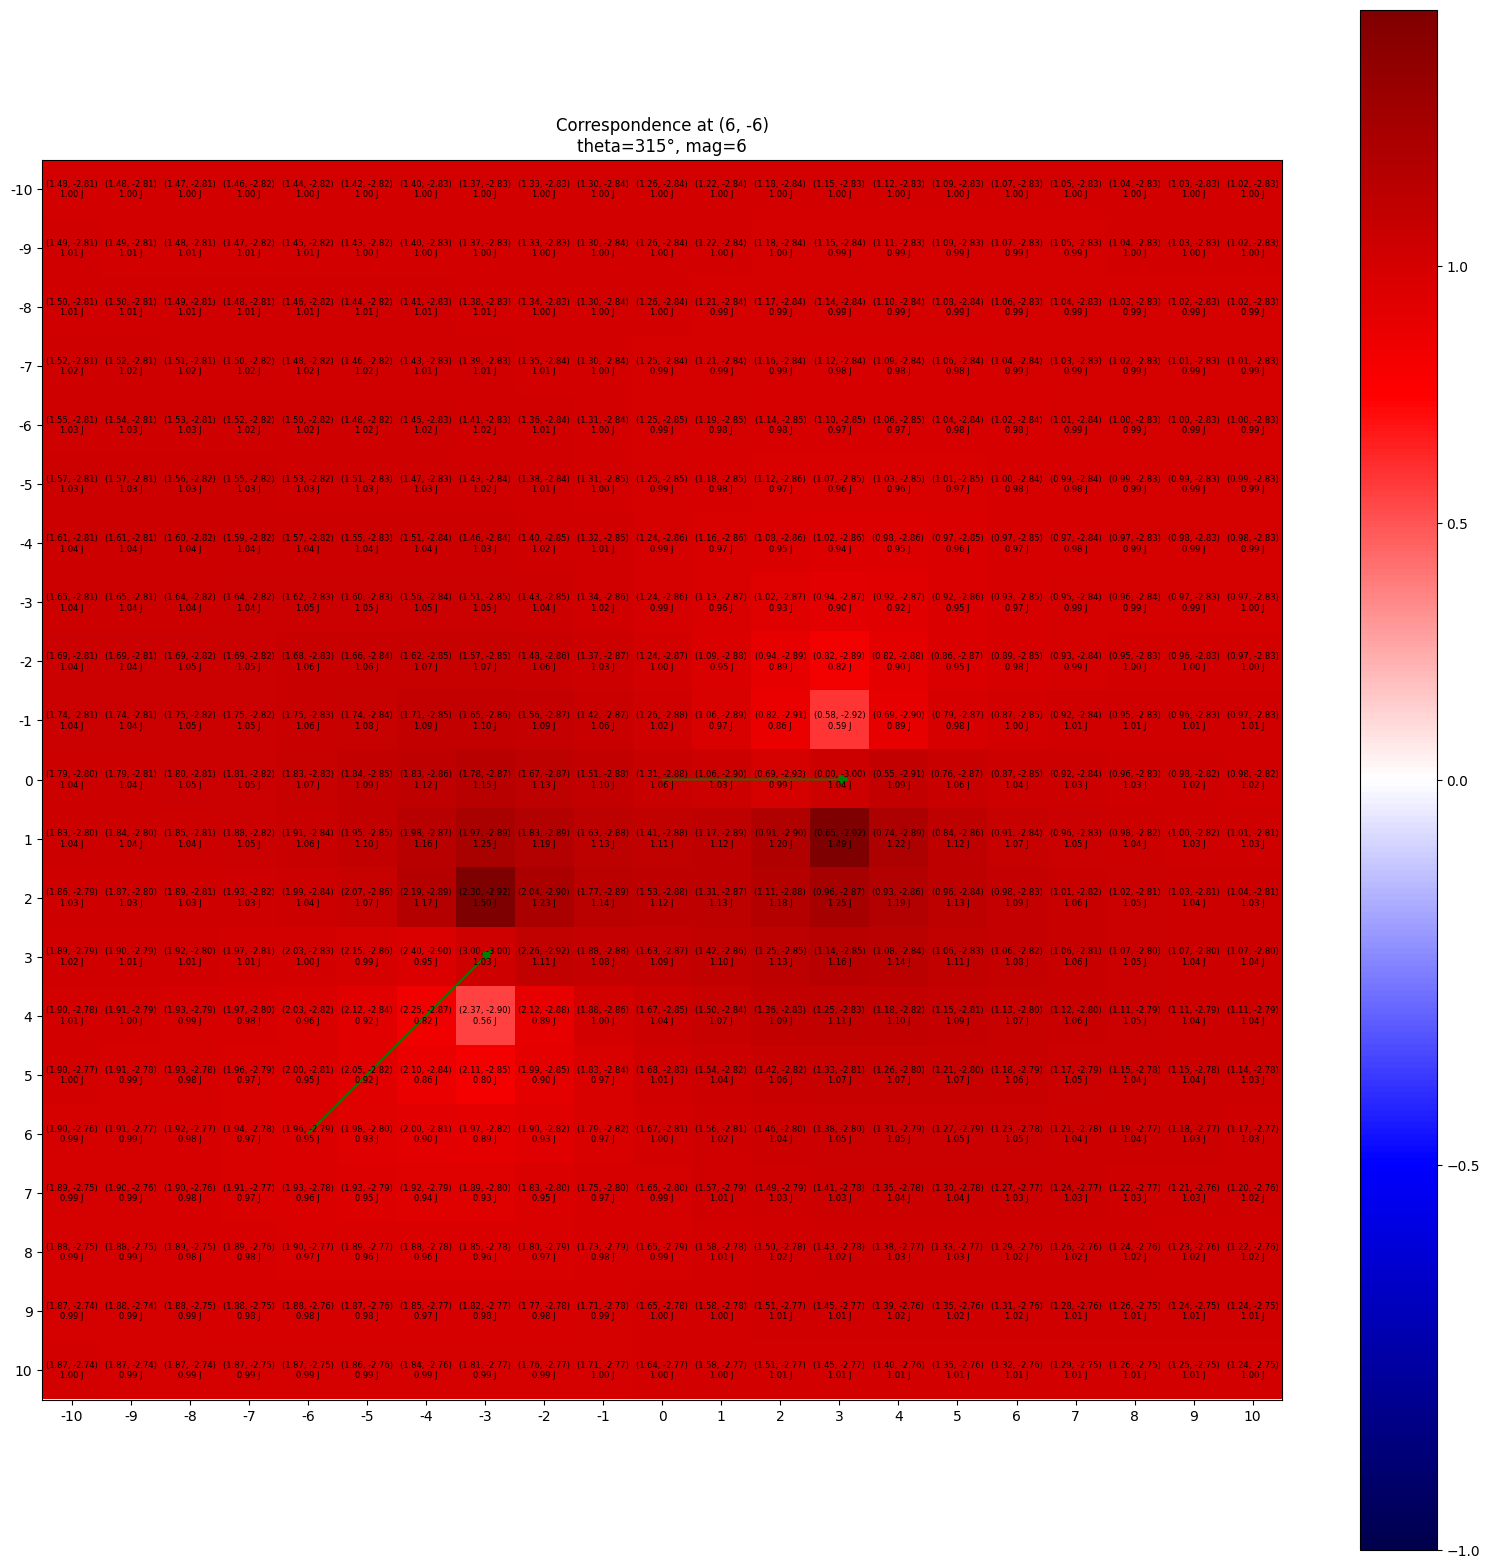

In [44]:
# Case 5
y, x = (2, -2)
theta = 315
magnitude = 2
n = 7
scale = 3

g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)
g2 = g1.upsample(scale)
g2.downsample(n).show(title=f"Correspondence at ({y * scale}, {x * scale}) (downscaled)\ntheta={theta}°, mag={magnitude * scale}")
g2.show(title=f"Correspondence at ({y * scale}, {x * scale})\ntheta={theta}°, mag={magnitude * scale}", figsize=(20, 20), fontsize=6)

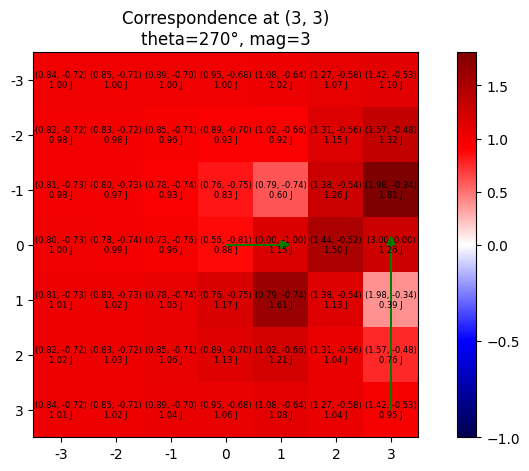

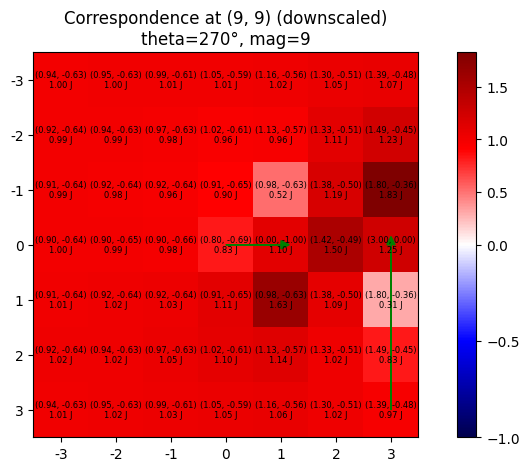

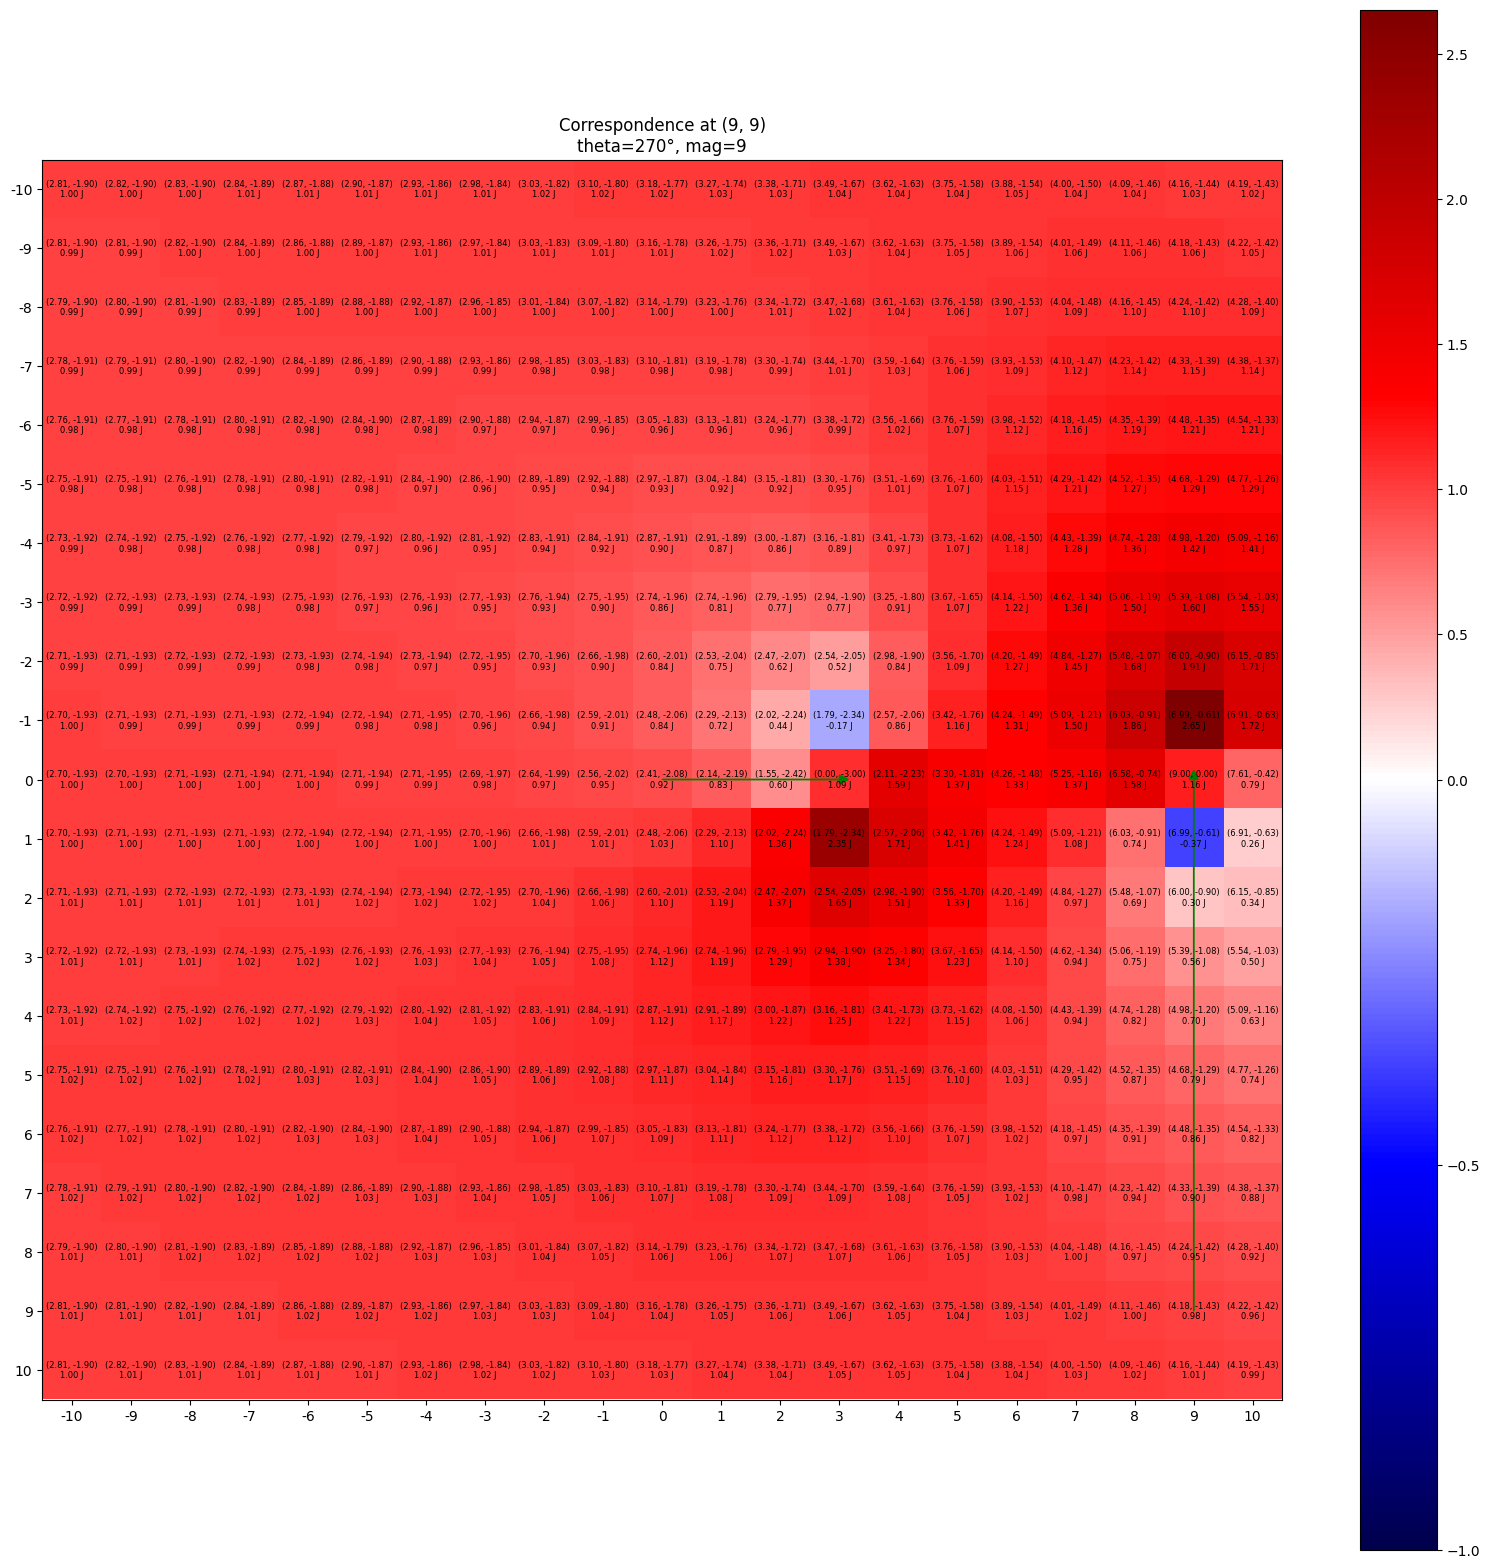

In [45]:
# Case 6
y, x = (3, 3)
theta = 270
magnitude = 3
n = 7
scale = 3

g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)
g2 = g1.upsample(scale)
g2.downsample(n).show(title=f"Correspondence at ({y * scale}, {x * scale}) (downscaled)\ntheta={theta}°, mag={magnitude * scale}")
g2.show(title=f"Correspondence at ({y * scale}, {x * scale})\ntheta={theta}°, mag={magnitude * scale}", figsize=(20, 20), fontsize=6)

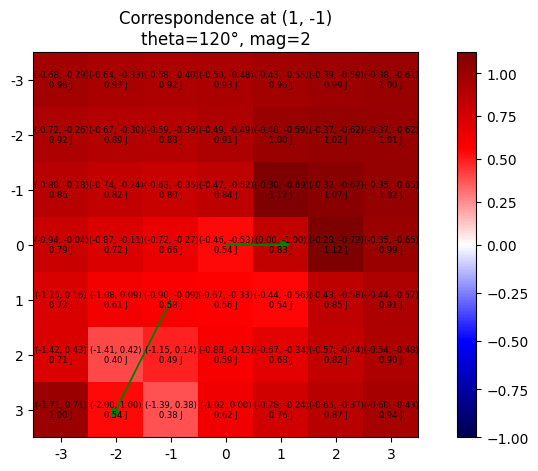

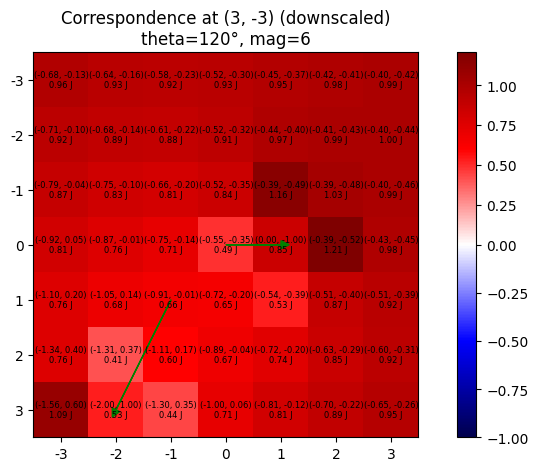

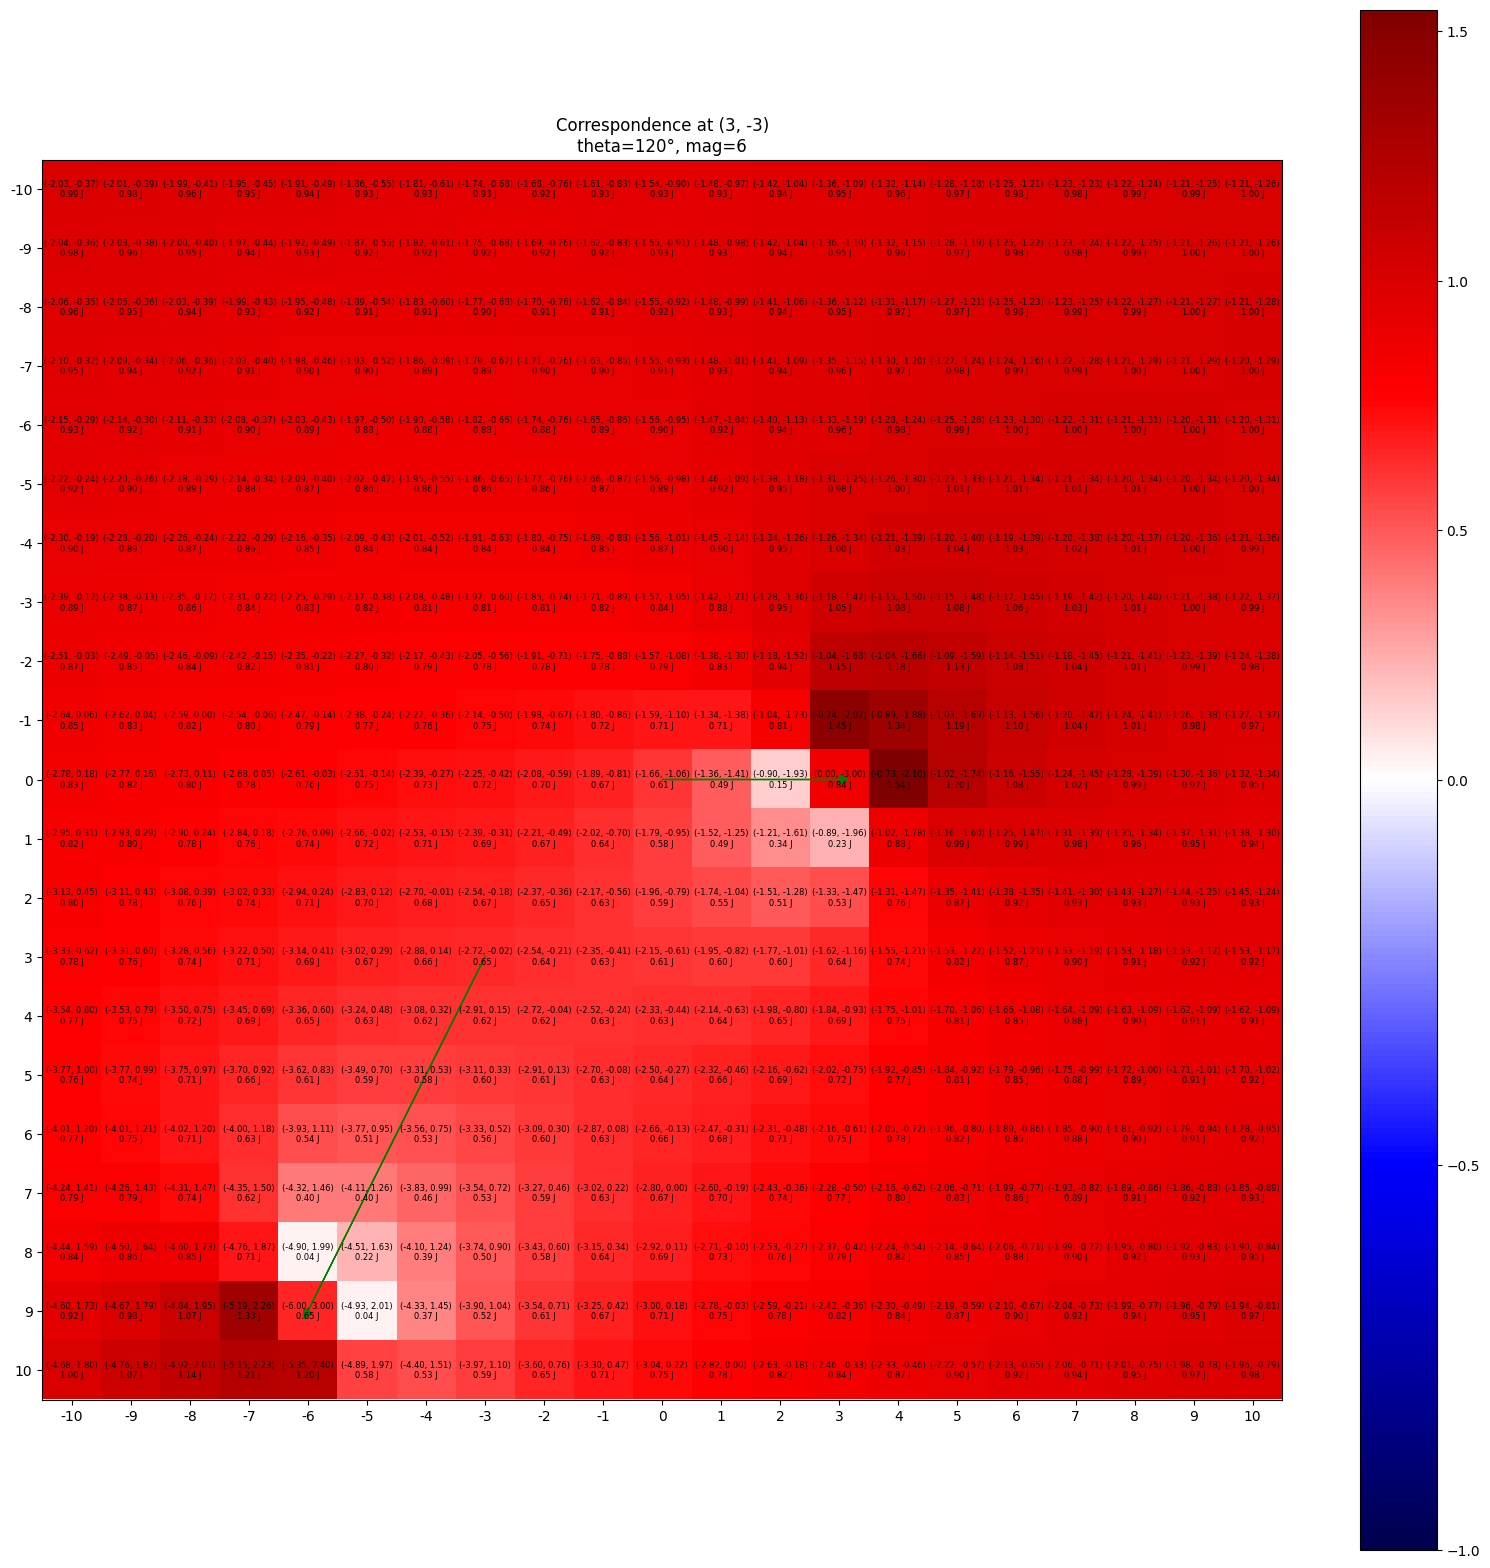

In [46]:
# Case 7
y, x = (1, -1)
theta = 120
magnitude = 2
n = 7
scale = 3

g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)
g2 = g1.upsample(scale)
g2.downsample(n).show(title=f"Correspondence at ({y * scale}, {x * scale}) (downscaled)\ntheta={theta}°, mag={magnitude * scale}")
g2.show(title=f"Correspondence at ({y * scale}, {x * scale})\ntheta={theta}°, mag={magnitude * scale}", figsize=(20, 20), fontsize=6)

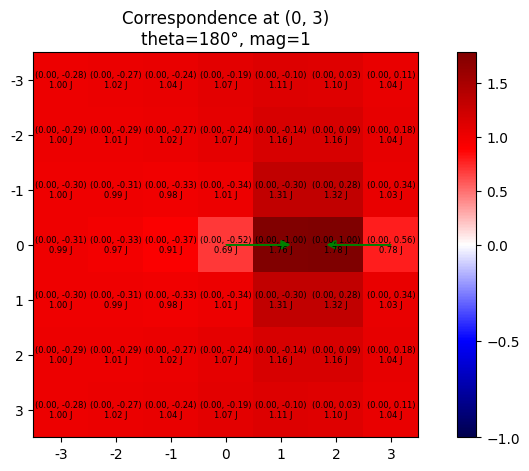

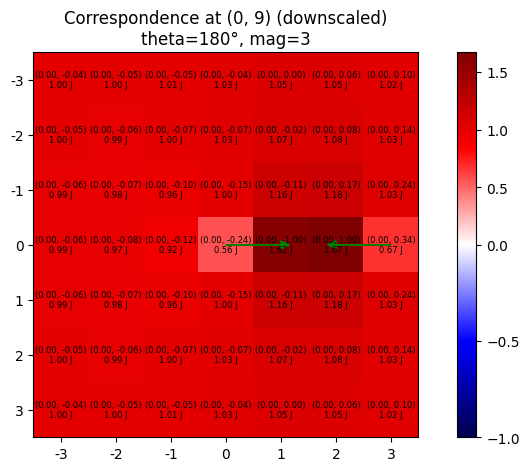

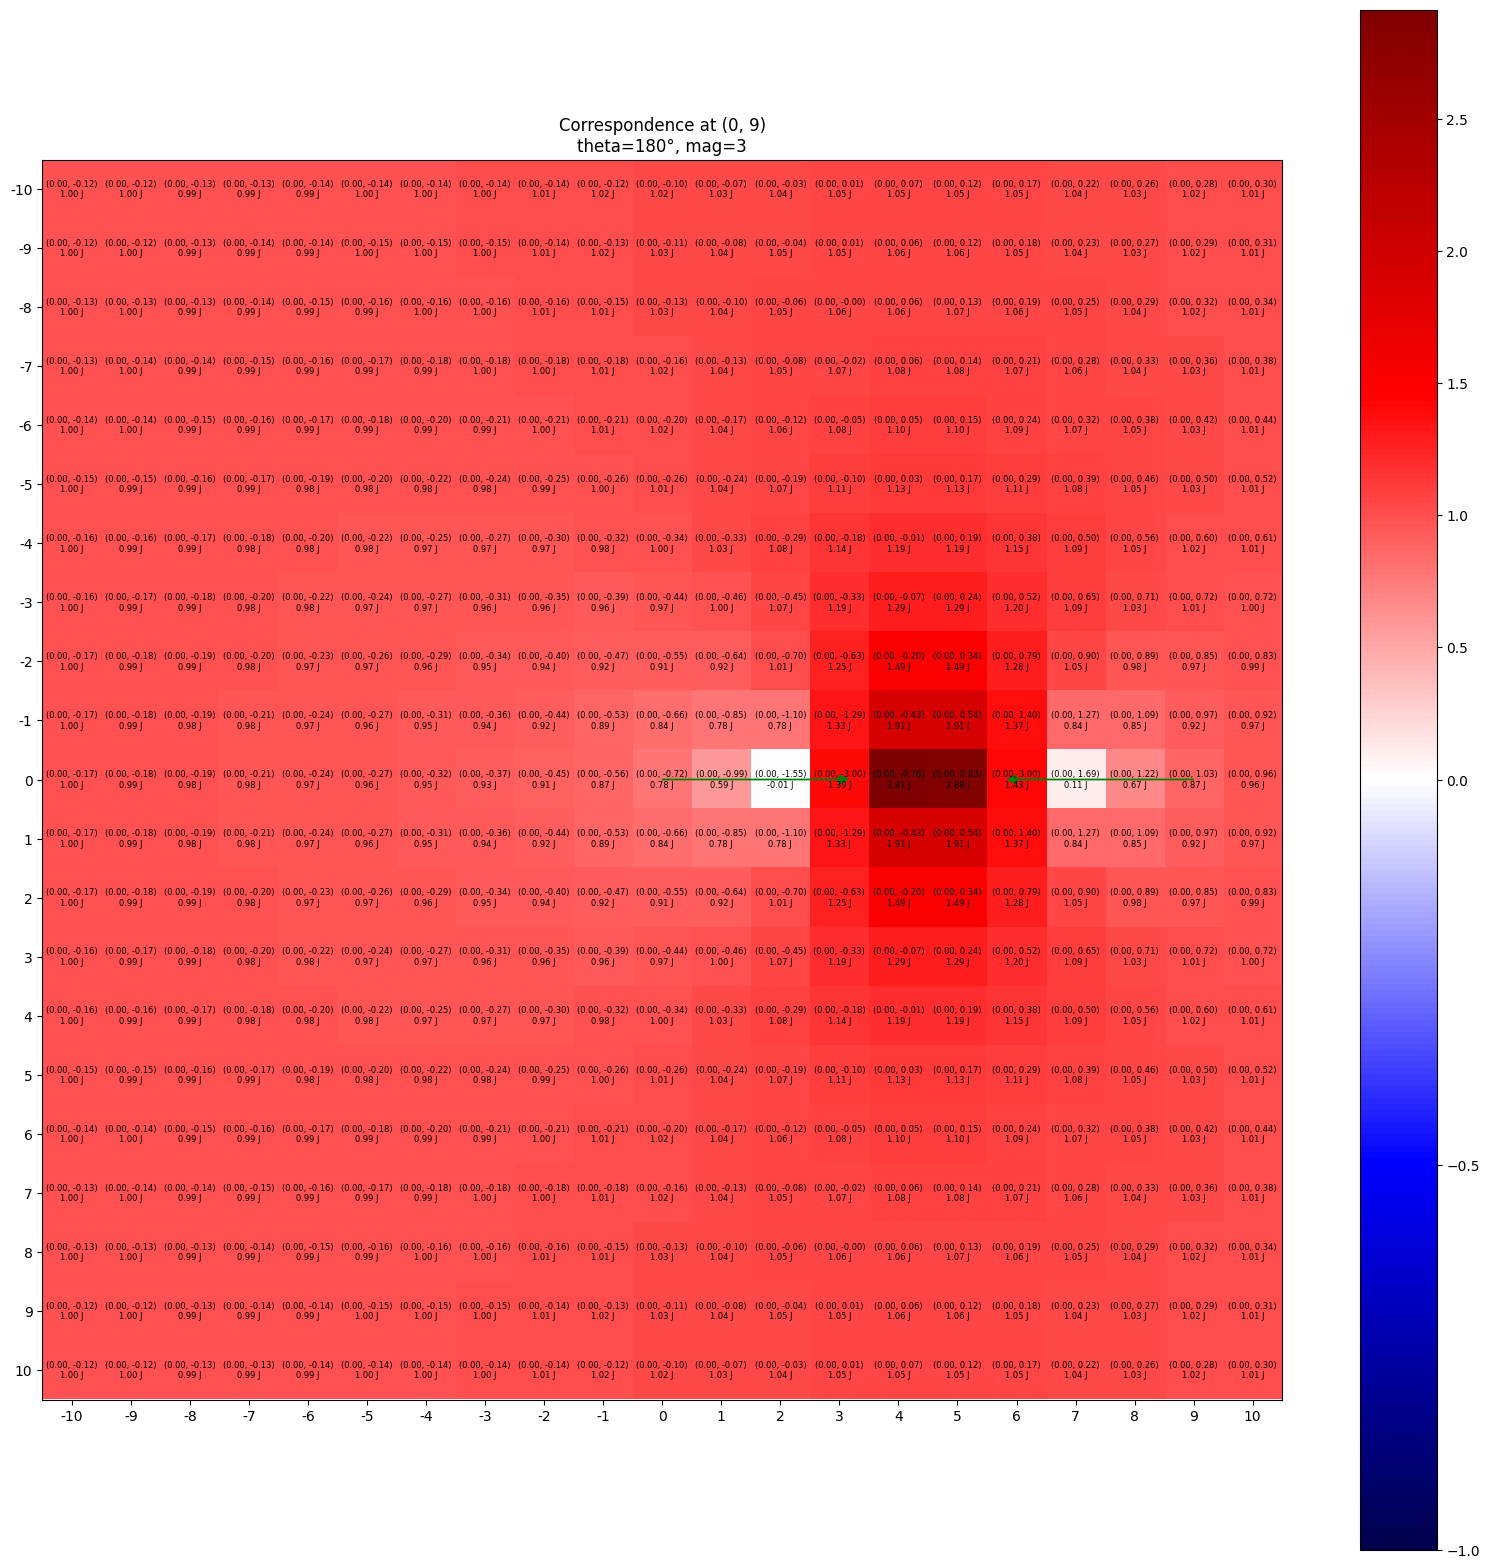

In [ ]:
# Case 8
y, x = (0, 3)
theta = 180
magnitude = 1
n = 7
scale = 3

g1 = create_case(y=y, x=x, theta=theta, magnitude=magnitude, n=n)
g2 = g1.upsample(scale)
g2.downsample(n).show(title=f"Correspondence at ({y * scale}, {x * scale}) (downscaled)\ntheta={theta}°, mag={magnitude * scale}")
g2.show(title=f"Correspondence at ({y * scale}, {x * scale})\ntheta={theta}°, mag={magnitude * scale}", figsize=(20, 20), fontsize=6)

### Scale both vectors

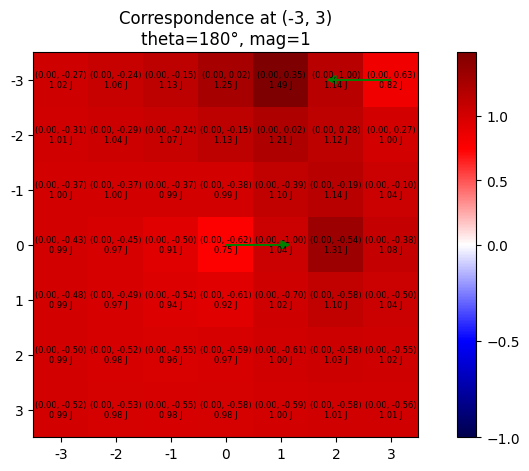

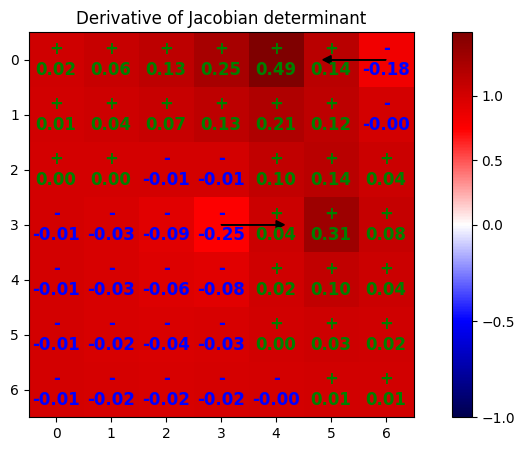

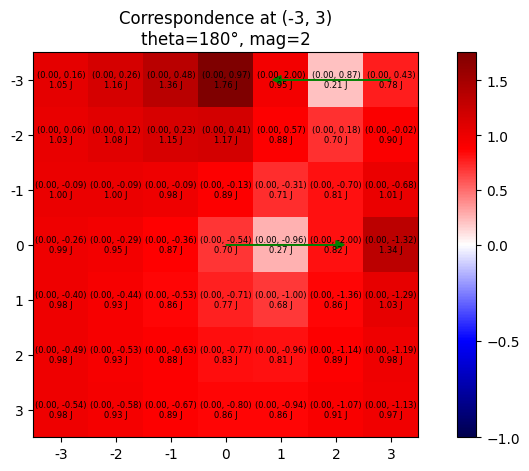

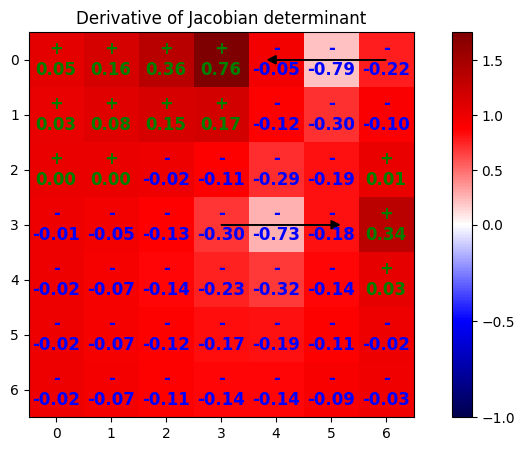

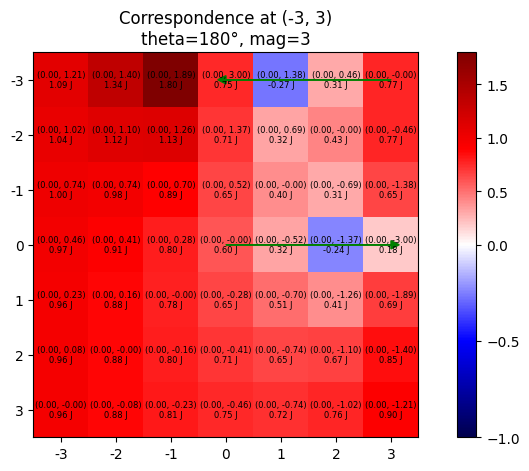

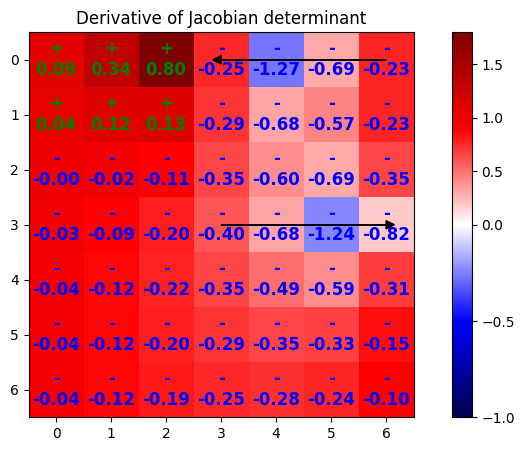

In [11]:
# Case 1
y, x = (-3, 3)
theta = 180
base_magnitude = 1
magnitude = 1
n = 7
g1 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude, magnitude=magnitude, n=n)
g1.show_derivative()
g2 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*2, magnitude=magnitude*2, n=n)
g2.show_derivative()
g3 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*3, magnitude=magnitude*3, n=n)
g3.show_derivative()

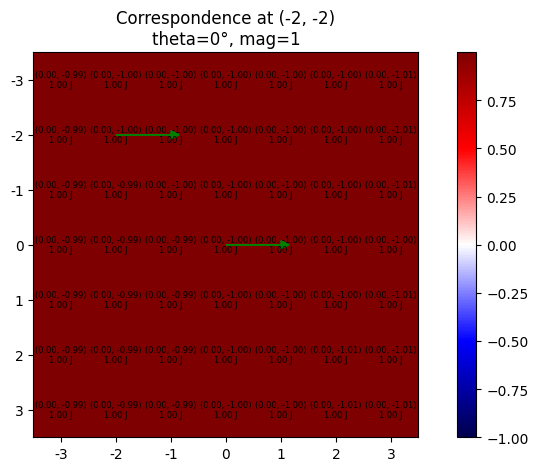

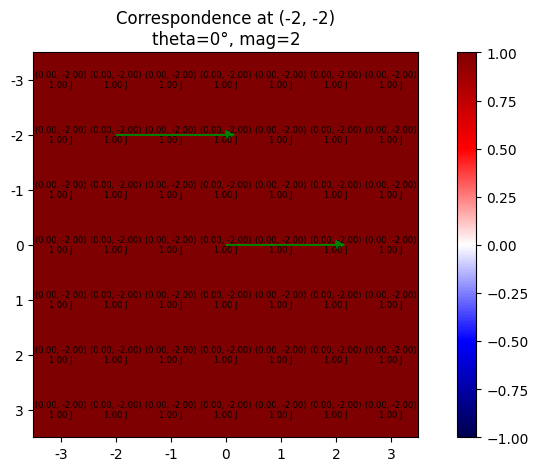

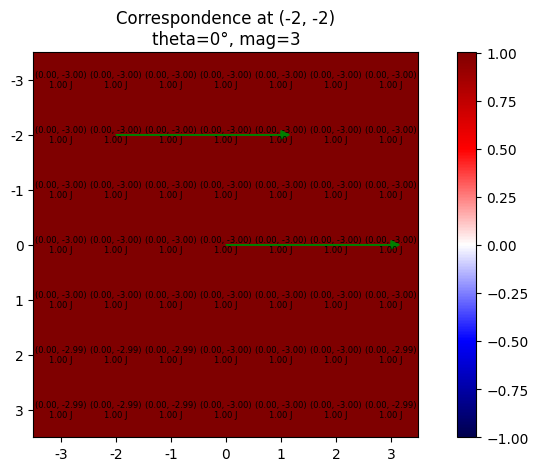

In [13]:
# Case 2
y, x = (-2, -2)
theta = 0
base_magnitude = 1
magnitude = 1
n = 7
g1 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude, magnitude=magnitude, n=n)
g2 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*2, magnitude=magnitude*2, n=n)
g3 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*3, magnitude=magnitude*3, n=n)

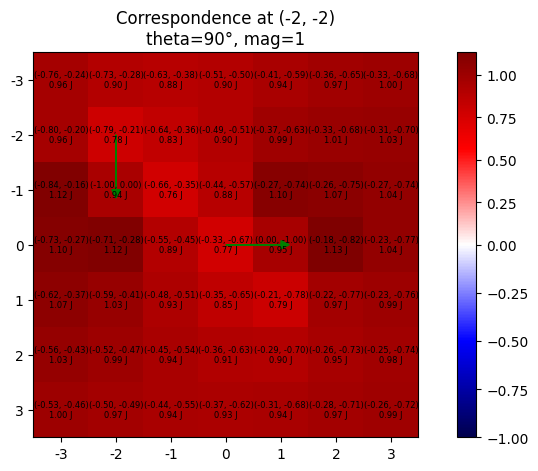

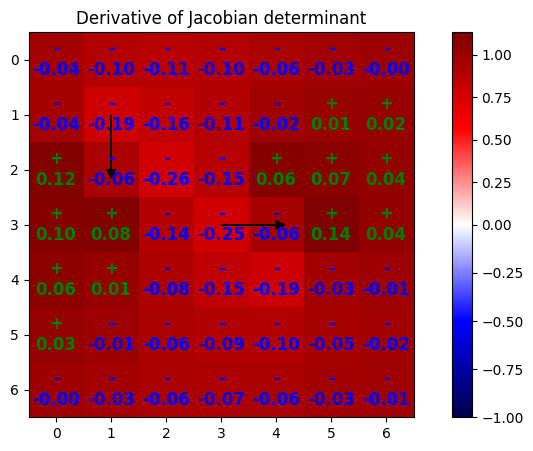

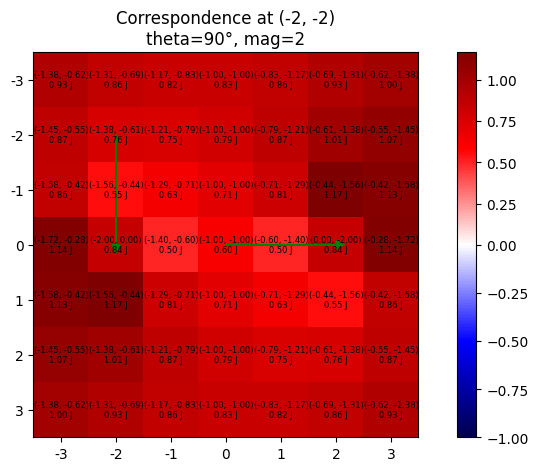

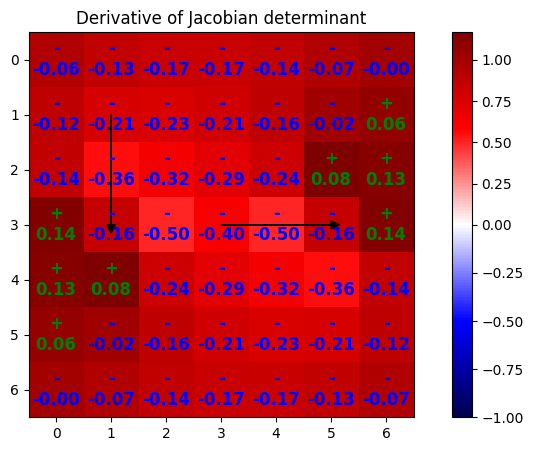

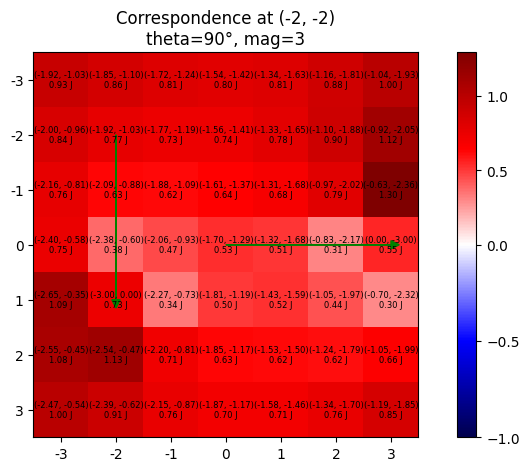

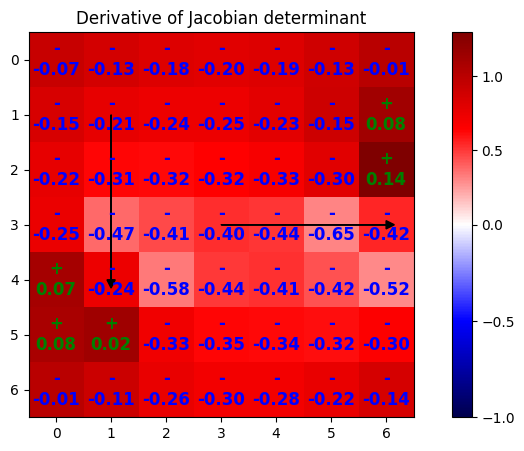

In [14]:
# Case 3
y, x = (-2, -2)
theta = 90
base_magnitude = 1
magnitude = 1
n = 7
g1 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude, magnitude=magnitude, n=n)
g1.show_derivative()
g2 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*2, magnitude=magnitude*2, n=n)
g2.show_derivative()
g3 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*3, magnitude=magnitude*3, n=n)
g3.show_derivative()

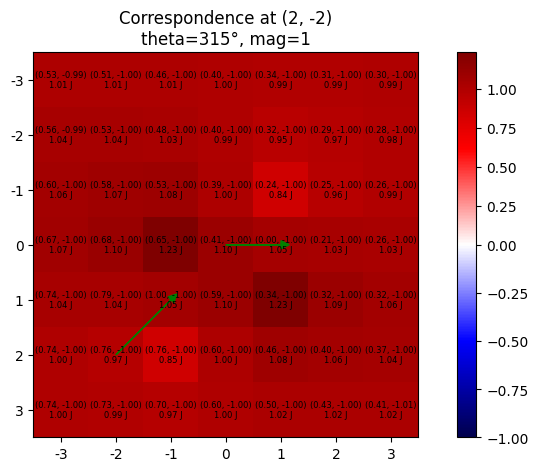

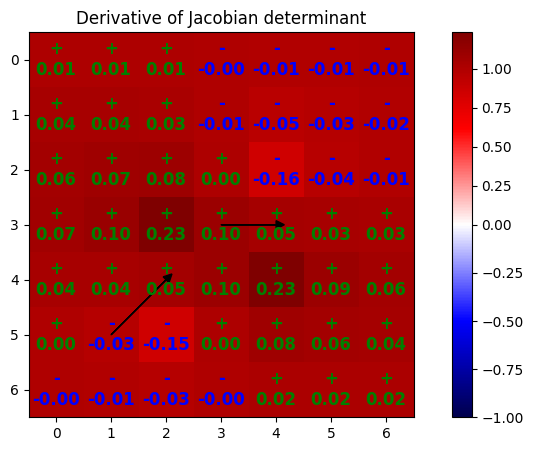

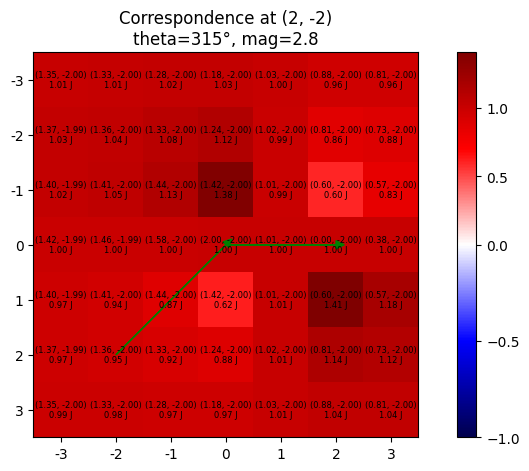

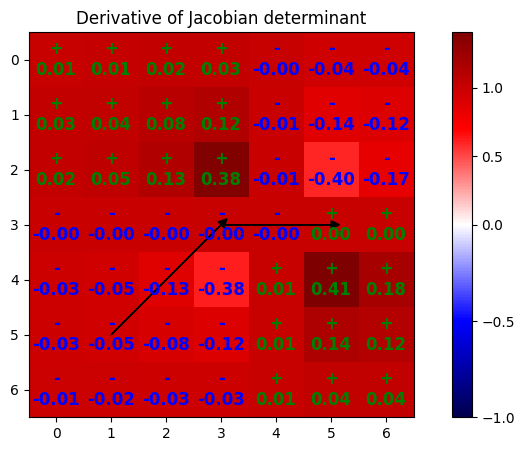

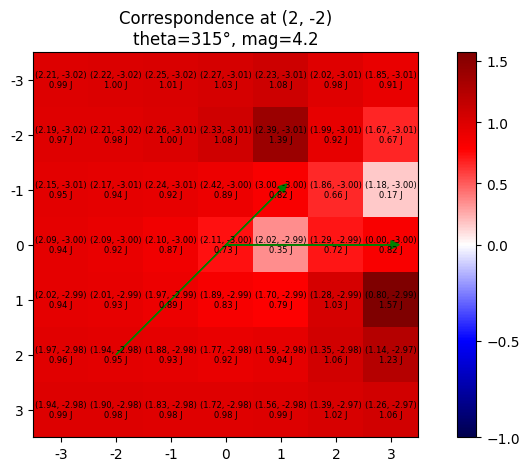

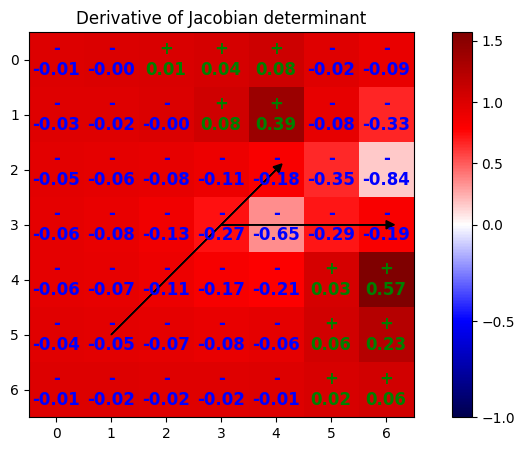

In [15]:
# Case 4
y, x = (2, -2)
theta = 315
base_magnitude = 1
magnitude = 1
n = 7
g1 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude, magnitude=magnitude, n=n)
g1.show_derivative()
g2 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*2, magnitude=magnitude*2.8, n=n)
g2.show_derivative()
g3 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*3, magnitude=magnitude*4.2, n=n)
g3.show_derivative()

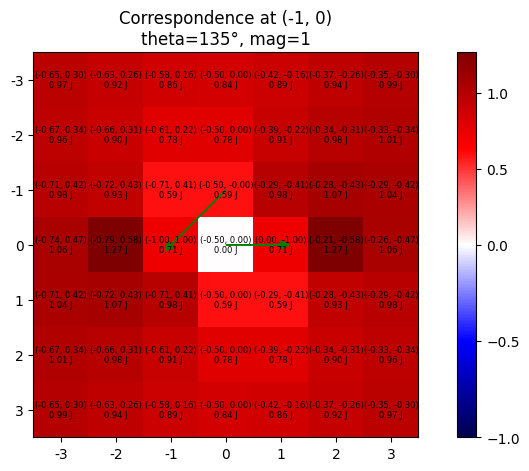

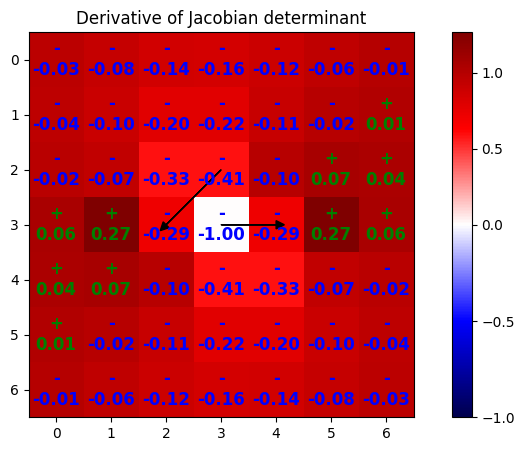

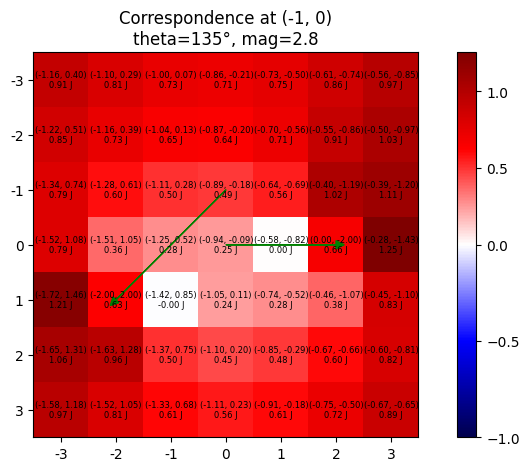

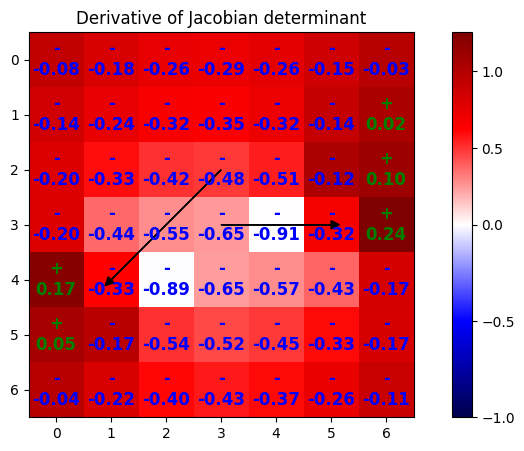

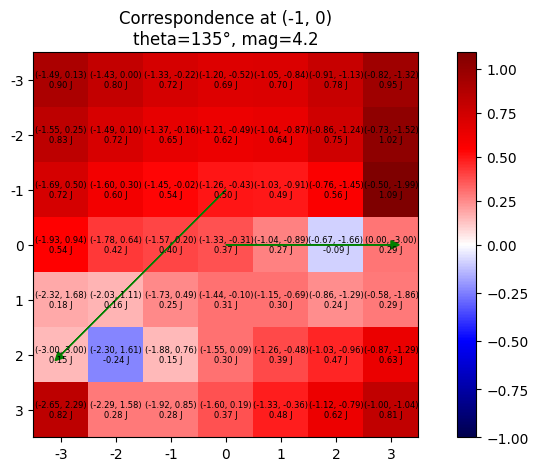

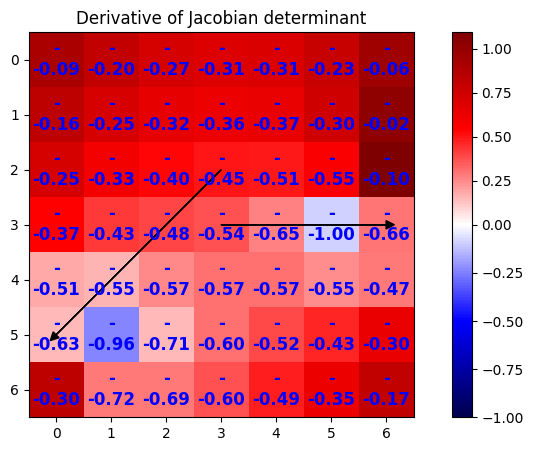

In [16]:
# Case 5
y, x = (-1, 0)
theta = 135
base_magnitude = 1
magnitude = 1
n = 7
g1 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude, magnitude=magnitude, n=n)
g1.show_derivative()
g2 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*2, magnitude=magnitude*2.8, n=n)
g2.show_derivative()
g3 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*3, magnitude=magnitude*4.2, n=n)
g3.show_derivative()

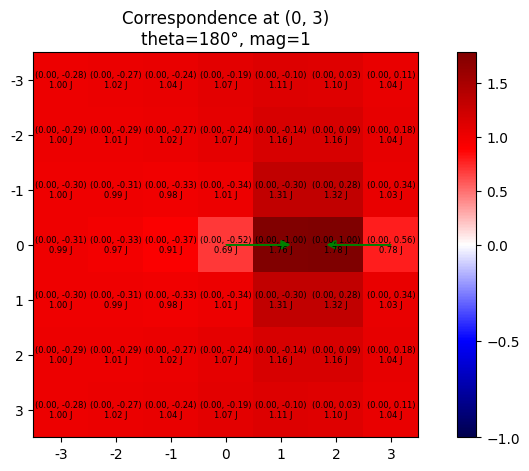

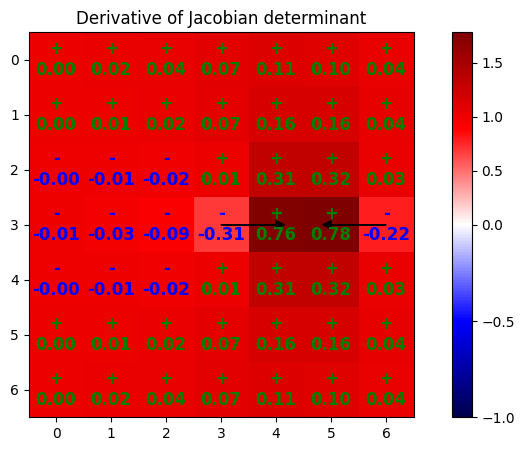

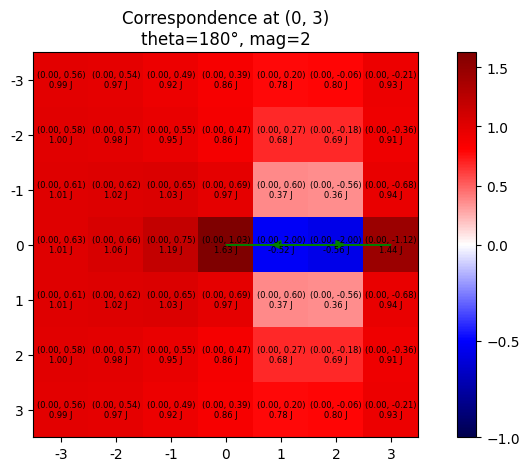

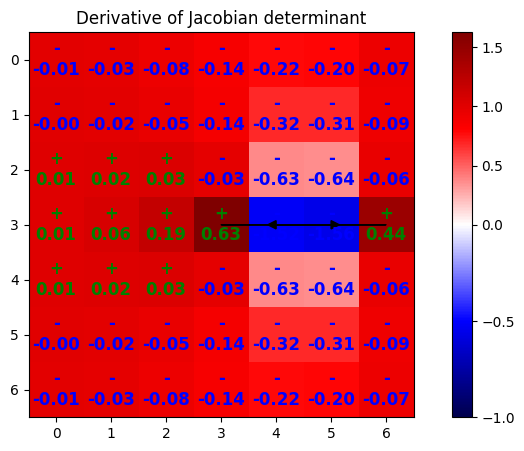

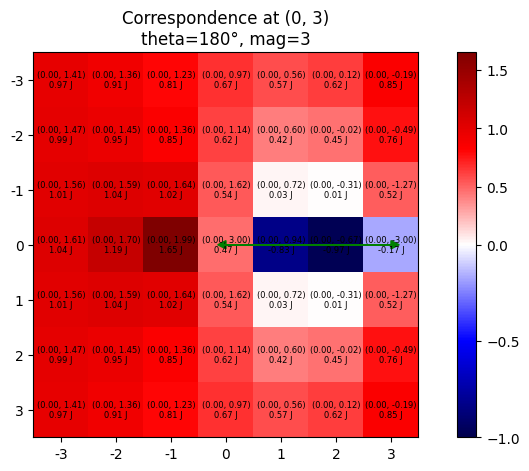

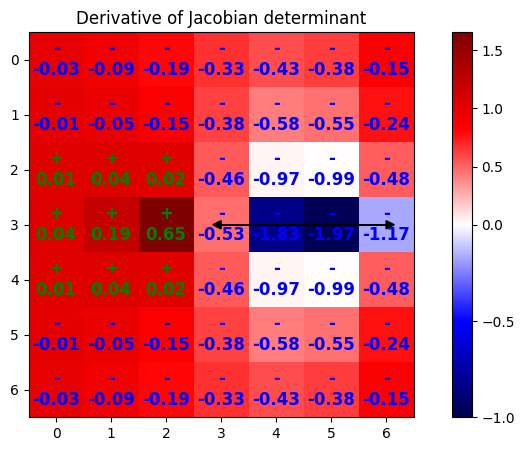

In [17]:
# Case 6
y, x = (0, 3)
theta = 180
base_magnitude = 1
magnitude = 1
n = 7
g1 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude, magnitude=magnitude, n=n)
g1.show_derivative()
g2 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*2, magnitude=magnitude*2, n=n)
g2.show_derivative()
g3 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude*3, magnitude=magnitude*3, n=n)
g3.show_derivative()

### Swap base correspondence positions

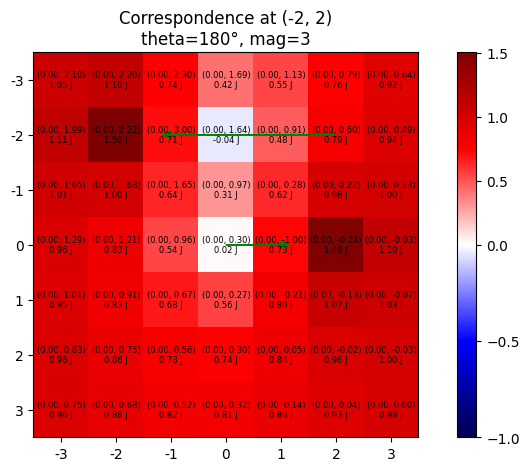

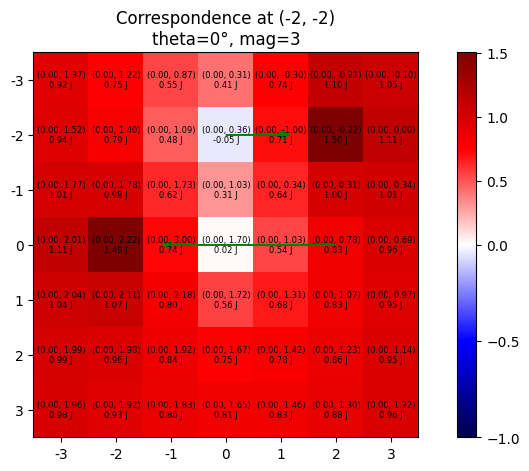

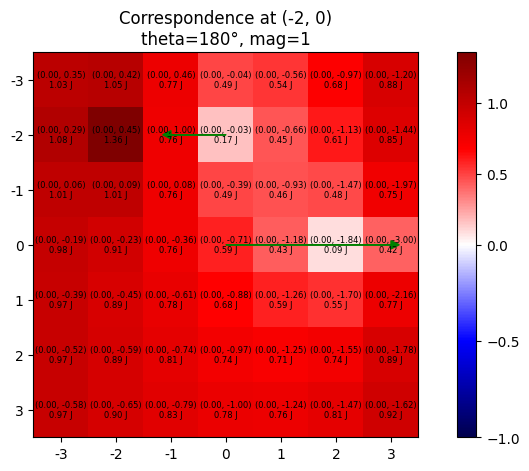

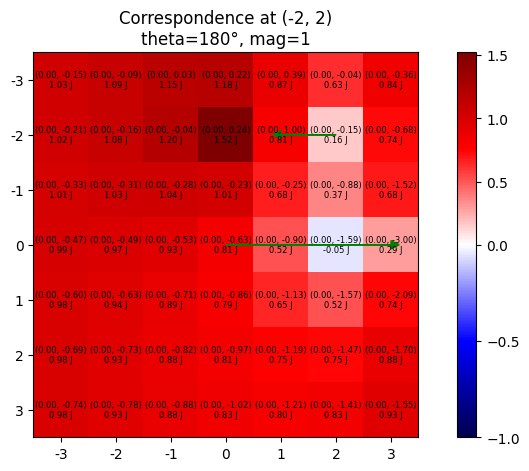

In [10]:
# Case 1
y, x = (-2, 2)
theta = 180
base_magnitude = 1
magnitude = 3
n = 7
g1 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude, magnitude=magnitude, n=n)


x, y = (-2, -2)
theta = 0
magnitude = 3
n = 7

# Create the correspondences
title = f"Correspondence at ({y}, {x})\ntheta={theta}°, mag={magnitude}"
base_mpoint, base_fpoint = create_correspondence(y=-2, x=0, angle=0, magnitude=1, n=n)
mpoint, fpoint = create_correspondence(y=0, x=2, angle=180, magnitude=3, n=n)
mpoints = np.vstack((base_mpoint, mpoint))
fpoints = np.vstack((base_fpoint, fpoint))
g = Grid(mpoints, fpoints, n=n)
g.show(title=title)


y, x = (-2, 0)
theta = 180
base_magnitude = 3
magnitude = 1
n = 7
g2 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude, magnitude=magnitude, n=n)

y, x = (-2, 2)
theta = 180
base_magnitude = 3
magnitude = 1
n = 7
g3 = create_case(y=y, x=x, theta=theta, base_magnitude=base_magnitude, magnitude=magnitude, n=n)

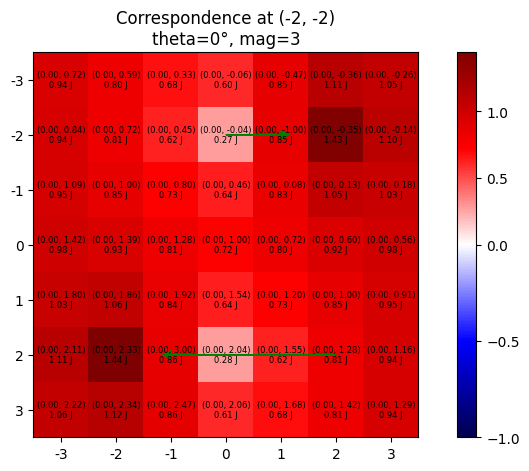

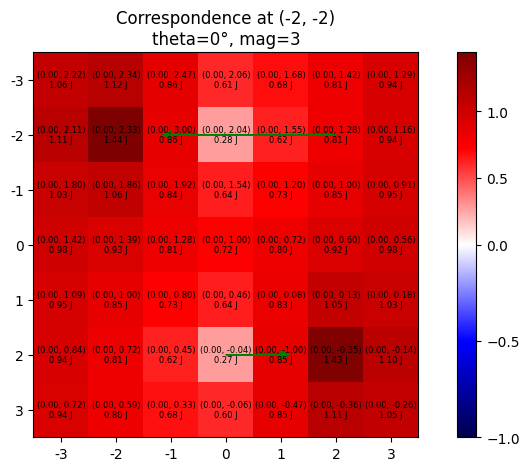

In [12]:
n = 7

# Create the correspondences
title = f"Correspondence at ({y}, {x})\ntheta={theta}°, mag={magnitude}"
base_mpoint, base_fpoint = create_correspondence(y=-2, x=0, angle=0, magnitude=1, n=n)
mpoint, fpoint = create_correspondence(y=2, x=2, angle=180, magnitude=3, n=n)
mpoints = np.vstack((base_mpoint, mpoint))
fpoints = np.vstack((base_fpoint, fpoint))
g = Grid(mpoints, fpoints, n=n)
g.show(title=title)


# Create the correspondences
title = f"Correspondence at ({y}, {x})\ntheta={theta}°, mag={magnitude}"
base_mpoint, base_fpoint = create_correspondence(y=2, x=0, angle=0, magnitude=1, n=n)
mpoint, fpoint = create_correspondence(y=-2, x=2, angle=180, magnitude=3, n=n)
mpoints = np.vstack((base_mpoint, mpoint))
fpoints = np.vstack((base_fpoint, fpoint))
g = Grid(mpoints, fpoints, n=n)
g.show(title=title)


### End

In [ ]:
x, y = (-2, -2)
theta = 0
magnitude = 3
n = 7

# Create the correspondences
title = f"Correspondence at ({y}, {x})\ntheta={theta}°, mag={magnitude}"
base_mpoint, base_fpoint = create_base_correspondence(magnitude=1, n=n)
mpoint, fpoint = create_correspondence(y=y, x=x, angle=theta, magnitude=magnitude, n=n)
mpoints = np.vstack((base_mpoint, mpoint))
fpoints = np.vstack((base_fpoint, fpoint))
g = Grid(mpoints, fpoints, n=n)
g.show(title=title)


y, x = (-9, 9)
theta = 180
base_magnitude = 2
magnitude = 12
n = 21

# Create the correspondences
title = f"Correspondence at ({y}, {x})\ntheta={theta}°, mag={magnitude}"
base_mpoint, base_fpoint = create_base_correspondence(magnitude=base_magnitude, n=n)
mpoint, fpoint = create_correspondence(y=y, x=x, angle=theta, magnitude=magnitude, n=n)
mpoints = np.vstack((base_mpoint, mpoint))
fpoints = np.vstack((base_fpoint, fpoint))
g = Grid(mpoints, fpoints, n=n)
g.show(title=title, figsize=(20, 20), fontsize=6)

# Neighborhood analysis

In [32]:
%load_ext autoreload
%autoreload 2

# Standard imports
from collections import defaultdict
import csv
import pickle 

# 3rd party imports
import numpy as np
np.set_printoptions(linewidth=1000)
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.notebook import tqdm

# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
def points_in_grid(points, center, grid_size=7):
    cz, cy, cx = center
    radius = grid_size // 2  # 3 for a 7x7 grid
    
    # Filtering points that lie within the 7x7 boundary
    filtered_indexes = [
        i for i, (z, y, x) in enumerate(points)
        if (cx - radius) <= x <= (cx + radius) and (cy - radius) <= y <= (cy + radius) and not np.array_equal(center, [z, y, x])
    ]
    
    return np.array(filtered_indexes)


def plot_points(center_mpoint, center_fpoint, mpoints, fpoints, jdet_field, grid_size=7):
    center_magnitude = np.linalg.norm(center_mpoint - center_fpoint)
    print(f"Center point magnitude: {center_magnitude:.2f}")
    
    filtered_indexes = points_in_grid(mpoints, center_mpoint, grid_size)
    filtered_mpoints = mpoints[filtered_indexes]
    filtered_fpoints = fpoints[filtered_indexes]
    
    plt.figure(figsize=(8, 8))
    
    norm = mcolors.TwoSlopeNorm(vmin=jdet_field.min(), vcenter=0, vmax=jdet_field.max())
    plt.imshow(jdet_field, cmap='seismic', norm=norm)
    plt.colorbar()
    
    plt.scatter(filtered_mpoints[:, 2], filtered_mpoints[:, 1], c='blue', label='Moving points')
    plt.scatter(filtered_fpoints[:, 2], filtered_fpoints[:, 1], c='green', label='Fixed points')
    
    # Draw arrows between corresponding points
    for m_point, f_point in zip(filtered_mpoints, filtered_fpoints):
        plt.arrow(m_point[2], m_point[1], f_point[2] - m_point[2], f_point[1] - m_point[1],
                  head_width=0.3, head_length=0.3, fc='black', ec='black')

    
    plt.scatter(center_mpoint[2], center_mpoint[1], c='red', label='Center point')
    plt.scatter(center_fpoint[2], center_fpoint[1], c='orange', label='Center point correspondence')
    plt.arrow(center_mpoint[2], center_mpoint[1], center_fpoint[2] - center_mpoint[2], center_fpoint[1] - center_mpoint[1],
              head_width=0.3, head_length=0.3, fc='black', ec='black')
    
    plt.xlim(center_mpoint[2] - grid_size // 2, center_mpoint[2] + grid_size // 2)
    plt.ylim(center_mpoint[1] - grid_size // 2, center_mpoint[1] + grid_size // 2)
    
    # Reverse y axis
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    #plt.legend()
    plt.show()

In [79]:
moving_path = "data/corrected_correspondences_count_touching/mpoints.npy"
fixed_path = "data/corrected_correspondences_count_touching/fpoints.npy"
lut_path = "output/final_case/lut_data_7x7.csv"
CURR_IDX = 350

mpoints = np.load(moving_path)
fpoints = np.load(fixed_path)

# Get only elements that are of the current index
mpoints = mpoints[mpoints[:, 0] == CURR_IDX]
fpoints = fpoints[fpoints[:, 0] == CURR_IDX]
mpoints[:, 0] = 0
fpoints[:, 0] = 0

resolution = np.zeros((1, 320, 456))
deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(resolution, mpoints, fpoints)
jdet_field = jacobian.sitk_jacobian_determinant(deformation)[0]

## Run code

-1.5707963267948966
4.71238898038469
Current point:
 [  0.  15. 188.] [  0.  10. 188.]
Current vector:
 [ 0. -5.  0.]
Current magnitude: 5.00
Current angle: 270.00
Center point magnitude: 5.00


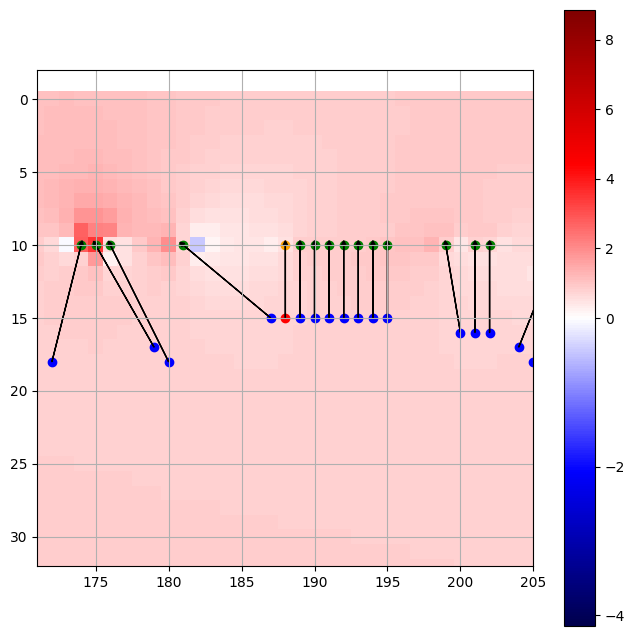

In [136]:
PT_IDX = 4  # 4

curr_mpoint = mpoints[PT_IDX]
curr_fpoint = fpoints[PT_IDX]
curr_vector = curr_fpoint - curr_mpoint
curr_magnitude = np.linalg.norm(curr_mpoint - curr_fpoint)

curr_theta_rad = np.arctan2(curr_vector[1], curr_vector[2])
print(curr_theta_rad)
if curr_theta_rad < 0:  # Ensure the angle is in the range [0, 2pi)
    curr_theta_rad += 2 * np.pi
print(curr_theta_rad)
curr_theta = np.abs(np.degrees(curr_theta_rad))
                
print("Current point:\n", curr_mpoint, curr_fpoint)
print("Current vector:\n", curr_vector)
print(f"Current magnitude: {curr_magnitude:.2f}")
print(f"Current angle: {curr_theta:.2f}")

plot_points(curr_mpoint, curr_fpoint, mpoints, fpoints, jdet_field, grid_size=35)

In [107]:
neighboring_points = points_in_grid(mpoints, curr_mpoint, grid_size=7 * curr_magnitude)

print("Current point:\n", curr_mpoint, curr_fpoint)
print(f"Current magnitude: {curr_magnitude:.2f}")
print(f"Current angle: {curr_theta:.2f}")
print(neighboring_points)
print()

for neighbor in neighboring_points:
    neighbor_mpoint = mpoints[neighbor]
    neighbor_fpoint = fpoints[neighbor]
    neighbor_vector = neighbor_fpoint - neighbor_mpoint
    neighbor_magnitude = np.linalg.norm(neighbor_mpoint - neighbor_fpoint)
    
    
    neighbor_theta_rad = np.arctan2(neighbor_vector[1], neighbor_vector[2])
    if neighbor_theta_rad < 0:  # Ensure the angle is in the range [0, 2pi)
        neighbor_theta_rad += 2 * np.pi
    neighbor_theta = np.abs(np.degrees(neighbor_theta_rad))
    
    neighbor_normalized_mag = neighbor_magnitude / curr_magnitude
    neighbor_normalized_angle = neighbor_theta - curr_theta
    if neighbor_normalized_angle < 0:
        neighbor_normalized_angle += 360

    print(f"Neighbor point ({neighbor}):\n", neighbor_mpoint, neighbor_fpoint)
    print(f"Neighbor magnitude: {neighbor_magnitude:.2f} ({neighbor_normalized_mag:.2f})")
    print(f"Neighbor angle: {neighbor_theta:.2f} ({neighbor_normalized_angle:.2f})")
    print()
    #plot_points(neighbor_mpoint, neighbor_fpoint, mpoints, fpoints, jdet_field, grid_size=35)
    
    


Current point:
 [  0.  15. 188.] [  0.  10. 188.]
Current magnitude: 5.00
Current angle: 270.00
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 45 55]

Neighbor point (0):
 [  0.  17. 179.] [  0.  10. 175.]
Neighbor magnitude: 8.06 (1.61)
Neighbor angle: 240.26 (330.26)

Neighbor point (1):
 [  0.  18. 172.] [  0.  10. 174.]
Neighbor magnitude: 8.25 (1.65)
Neighbor angle: 284.04 (14.04)

Neighbor point (2):
 [  0.  18. 180.] [  0.  10. 176.]
Neighbor magnitude: 8.94 (1.79)
Neighbor angle: 243.43 (333.43)

Neighbor point (3):
 [  0.  15. 187.] [  0.  10. 181.]
Neighbor magnitude: 7.81 (1.56)
Neighbor angle: 219.81 (309.81)

Neighbor point (5):
 [  0.  15. 189.] [  0.  10. 189.]
Neighbor magnitude: 5.00 (1.00)
Neighbor angle: 270.00 (0.00)

Neighbor point (6):
 [  0.  15. 190.] [  0.  10. 190.]
Neighbor magnitude: 5.00 (1.00)
Neighbor angle: 270.00 (0.00)

Neighbor point (7):
 [  0.  15. 191.] [  0.  10. 191.]
Neighbor magnitude: 5.00 (1.00)
Neighbor angle: 270.00 (0.00)

Neighbor point (8):


In [141]:
#Neighbor point (3):
# [  0.  15. 187.] [  0.  10. 181.]
#Neighbor magnitude: 7.81 (1.56)
#Neighbor angle: 219.81 (309.81)

target_mpoint = mpoints[3]
target_fpoint = fpoints[3]

print("Current point:\n", curr_mpoint, curr_fpoint)
print("Target point:\n", target_mpoint, target_fpoint)

# Compute center difference
center = np.array([0, 17, 17])
center_difference = center - curr_mpoint
print("Center difference:\n", center_difference)

# Move current point to center
curr_mdiff = curr_mpoint + center_difference
curr_fdiff = curr_fpoint + center_difference
print("Current point moved to center:\n", curr_mdiff, curr_fdiff)

# Move target point to center
target_mdiff = target_mpoint + center_difference
target_fdiff = target_fpoint + center_difference
print("Target point moved to center:\n", target_mdiff, target_fdiff)

# Scale down to 7x7 grid
curr_mdiff[1:] -= 35 // 2
curr_mdiff[1:] //= 5
curr_mdiff[1:] += 7 // 2

curr_fdiff[1:] -= 35 // 2
curr_fdiff[1:] //= 5
curr_fdiff[1:] += 7 // 2

target_mdiff[1:] -= 35 // 2
target_mdiff[1:] //= 5
target_mdiff[1:] += 7 // 2

target_fdiff[1:] -= 35 // 2
target_fdiff[1:] //= 5
target_fdiff[1:] += 7 // 2


print("Current point moved to center and scaled down:\n", curr_mdiff, curr_fdiff)
print("Target point moved to center and scaled down:\n", target_mdiff, target_fdiff)

Current point:
 [  0.  15. 188.] [  0.  10. 188.]
Target point:
 [  0.  15. 187.] [  0.  10. 181.]
Center difference:
 [   0.    2. -171.]
Current point moved to center:
 [ 0. 17. 17.] [ 0. 12. 17.]
Target point moved to center:
 [ 0. 17. 16.] [ 0. 12. 10.]
Current point moved to center and scaled down:
 [0. 3. 3.] [0. 2. 3.]
Target point moved to center and scaled down:
 [0. 3. 2.] [0. 2. 1.]


[0. 3. 2.]


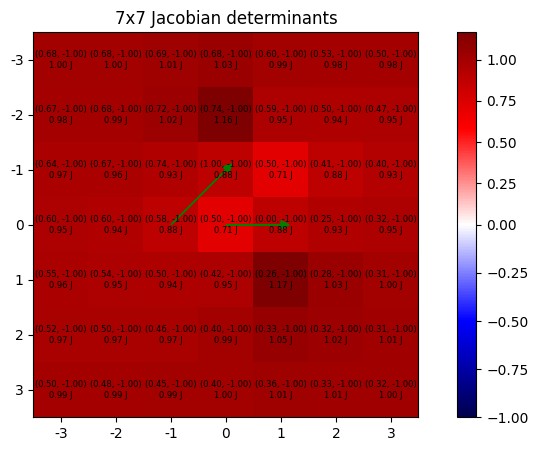

In [152]:
base_mpt, base_fpt = create_base_correspondence(magnitude=1, n=7)
new_mpt, new_fpt = create_correspondence(y=target_mdiff[1], x=target_mdiff[2], angle=309.81, magnitude=1.56, n=7, mpoint=target_mdiff)
print(new_mpt)

new_mpts = np.vstack((base_mpt, new_mpt))
new_fpts = np.vstack((base_fpt, new_fpt))

g = Grid(new_mpts, new_fpts, n=7)
g.show()

# (1.56)
#Neighbor angle: 219.81 (309.81)

In [ ]:
downsampled_displacement_field = np.zeros((3, 1, n, n))
scale = self.n // n
mpoints = []
fpoints = []

# Convert current mpoints and fpoints to downsampled locations
for i in range(len(self.mpoints)):
    mpt = self.mpoints[i].copy()
    fpt = self.fpoints[i].copy()
    # Compute new locations
    mpt[1:] -= self.n // 2
    mpt[1:] //= scale
    mpt[1:] += n // 2
    fpt[1:] -= self.n // 2
    fpt[1:] //= scale
    fpt[1:] += n // 2

## Visualization test for Heemmanshuu

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (11).

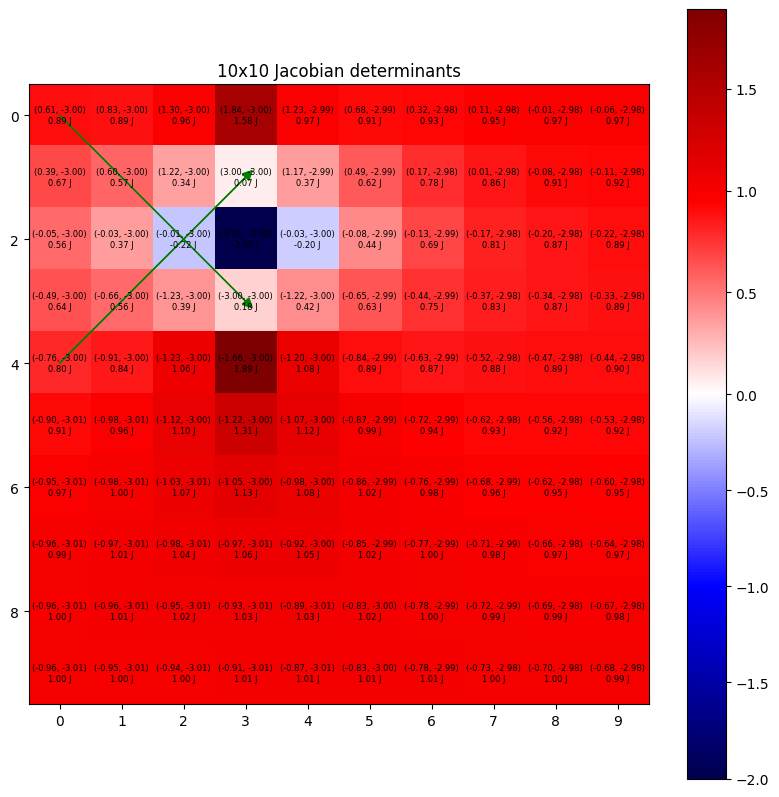

In [26]:
msample = np.array([
    [0, 0, 0],
    [0, 4, 0],
])
fsample = np.array([
    [0, 3, 3],
    [0, 1, 3],
])

#base_mpt, base_fpt = create_base_correspondence(magnitude=1, n=7)
#new_mpt, new_fpt = create_correspondence(y=target_mdiff[1], x=target_mdiff[2], angle=309.81, magnitude=1.56, n=7, mpoint=target_mdiff)
#print(new_mpt)

#new_mpts = np.vstack((base_mpt, new_mpt))
#new_fpts = np.vstack((base_fpt, new_fpt))

g = Grid(msample, fsample, n=10)
g.show(fontsize=6, figsize=(10, 10))